# Calculating the difference in mean state
This notebook focuses on the changes to the mean state of the future projectd in our model

In [510]:
import xarray as xr
import now
import numpy as np
import dask as da
import scipy.stats as stats
import time
import pandas as pd
import cartopy.crs as ccrs
import seaborn as sns
from datetime import date
import cmclimate.cm as cmc
from matplotlib import pyplot as plt
from dask.distributed import LocalCluster, Client
from cartopy import config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cluster = LocalCluster(processes=False, local_dir= "/g/data1a/e14/rm6294/dask-workers")
client = Client(cluster)
client

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


<Client: scheduler='inproc://10.0.64.22/28862/1' processes=1 cores=8>

In [529]:
# Plotting stuff
plt.rcParams["figure.figsize"] = [16,9]
sns.set()
#sns.set(rc={'axes.facecolor':'white', 'grid.color' : 'black'}) <- sets background of plots to be white and makes grid lines black
cmap_dif = 'bwr'
cmap_temp = 'hot_r'

In [4]:
# Defining chunk sizes
x_chunk = 120
y_chunk = 90
t_chunk = 365

In [5]:
# files stored in Guillaumes East Coast Low (ECL) directory
mean_dir = '/g/data1a/e14/gs9353/POST-PROCESS/ECLs/'
# We slice away the troublesome regions. Also fix nav_lon
mean_file = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_mean.nc').isel(x = slice(5,-5), y = slice(5,-50))
mean_file['nav_lon'] = mean_file['nav_lon'] % 360

# Do the same for EKE
EKE = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_Eddy_Kinetic_Energy.nc').isel(x = slice(5,-5), y = slice(5,-50))
EKE['nav_lon'] = EKE['nav_lon'] % 360
'''
I think Guillaume has changed the file name for the sst stuff. Yup he has - section needs to stay updated
# Loading sst
cfg = 'present_vs_future.ini'
# mld = Mixed Layer Depth
sst = now.io.open_nemo_griddata_from_zarr(cfg, grid='T')['tos']
''';

In [6]:
seas_file = xr.open_zarr(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_T_2D_seasonal_cycle.zarr')
seas_file['nav_lon'] = seas_file['nav_lon'] % 360 

In [7]:
# Makes plotting easier
for i in (mean_file, EKE, seas_file):
    i['nav_lon'].attrs['units'] = 'degrees_east'
    i['nav_lon'].attrs['long_name'] = 'Longitude'
    i['nav_lon'].attrs['standard_name'] = 'longitude'

## Eddy Kinetic Energy

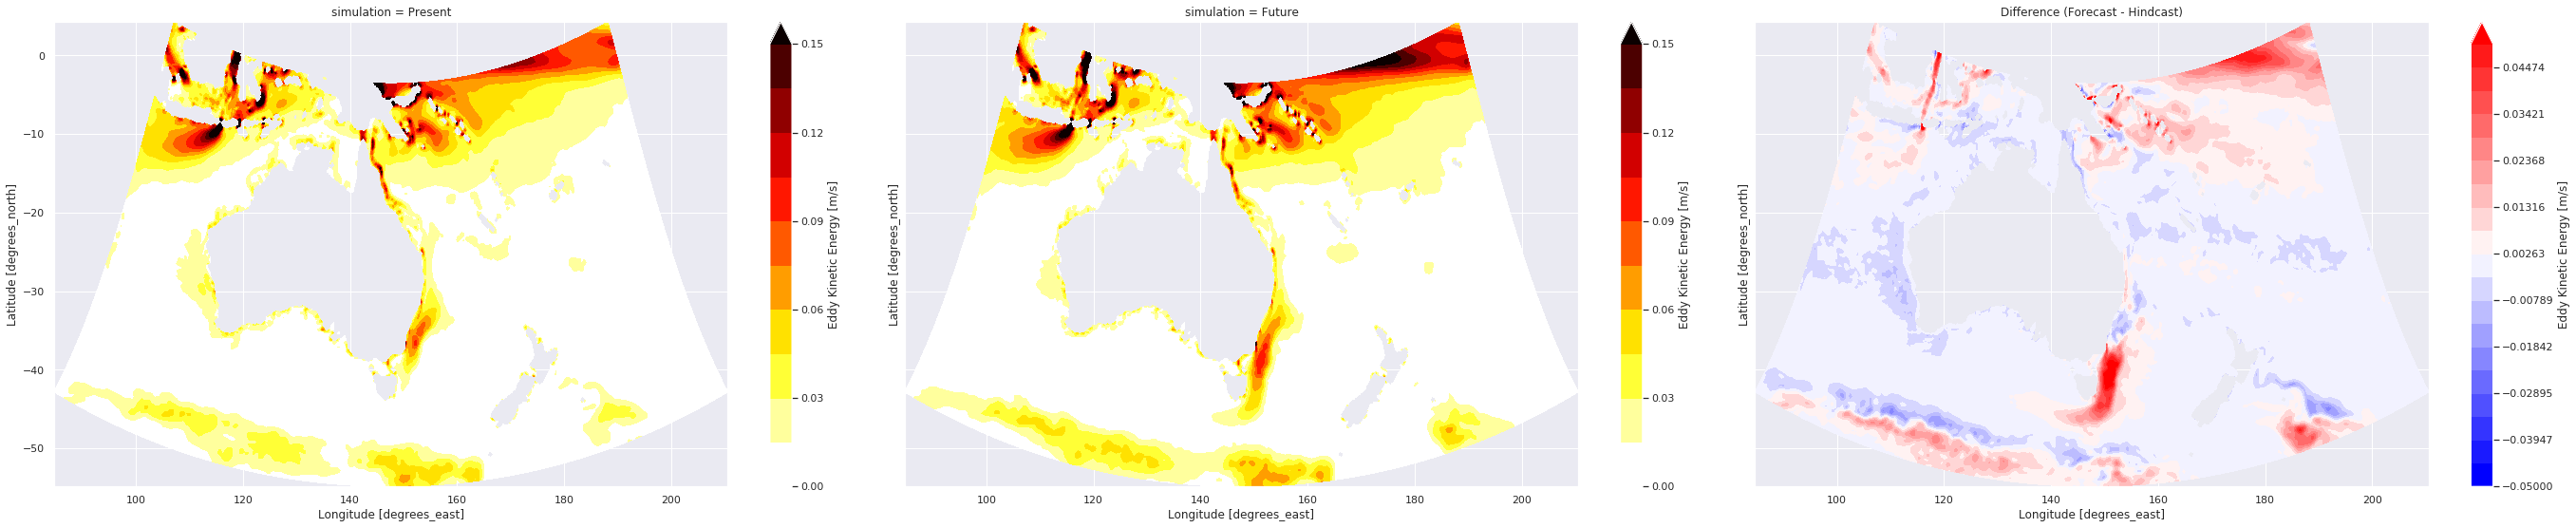

In [530]:
fig, axes = plt.subplots(1,3, sharey = True, figsize = (48, 9))
vmin, vmax = (0, 0.15)
vmin1, vmax1 = (-0.05, 0.05)
EKE.sel(simulation = 'Present')['eke'].plot.contourf(levels = 11, ax = axes[0], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cmap = cmap_temp,
                                            cbar_kwargs = {'label':'Eddy Kinetic Energy [m/s]'})
EKE.sel(simulation = 'Future')['eke'].plot.contourf(levels = 11, ax = axes[1], x = 'nav_lon', y = 'nav_lat', vmin = vmin, vmax = vmax, cmap = cmap_temp,
                                          cbar_kwargs = {'label':'Eddy Kinetic Energy [m/s]'})
(EKE.sel(simulation='Future')-EKE.sel(simulation='Present'))['eke'].plot.contourf(levels = 20, x='nav_lon', y = 'nav_lat', ax = axes[2], vmin = vmin1, vmax = vmax1, 
                                                                               cmap = cmap_dif, cbar_kwargs = {'label':'Eddy Kinetic Energy [m/s]'});
axes[2].set_title('Difference (Forecast - Hindcast)');
fig.subplots_adjust(wspace=0.01)

#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/eke_diff.png')

## SST  

In [8]:
# Only have to do this because Guillaume has moved the normal file
sstPast = xr.open_zarr('/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_v1/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Present')
sstFut = xr.open_zarr('/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_ALL/cordex24-BMJv2_BILAP_ALL_1d_1990_2008_grid_T_2D.zarr')['tos'].sel(simulation = 'Future')

PermissionError: [Errno 13] Permission denied: '/g/data1a/e14/gs9353/NOW_OUTPUTS/cordex24-BMJv2_BILAP_v1/cordex24-BMJv2_BILAP_1d_1990_2008_grid_T_2D.zarr/.zgroup'

In [31]:
sst_diff = sstFut - sstPast
# Calculating the difference in max SSTA for each grid cell
max_sst_diff = sst_diff.isel(x = slice(5,-5), y = slice(5,-50)).max('time_counter').compute()
max_sst_diff['nav_lon'] = max_sst_diff['nav_lon'] % 360 
# Calculating the difference in mean SSTA for each grid cell
mean_sst = mean_file['tos']
mean_sst_diff = mean_sst.sel(simulation = 'Future') - mean_sst.sel(simulation = 'Present') 

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


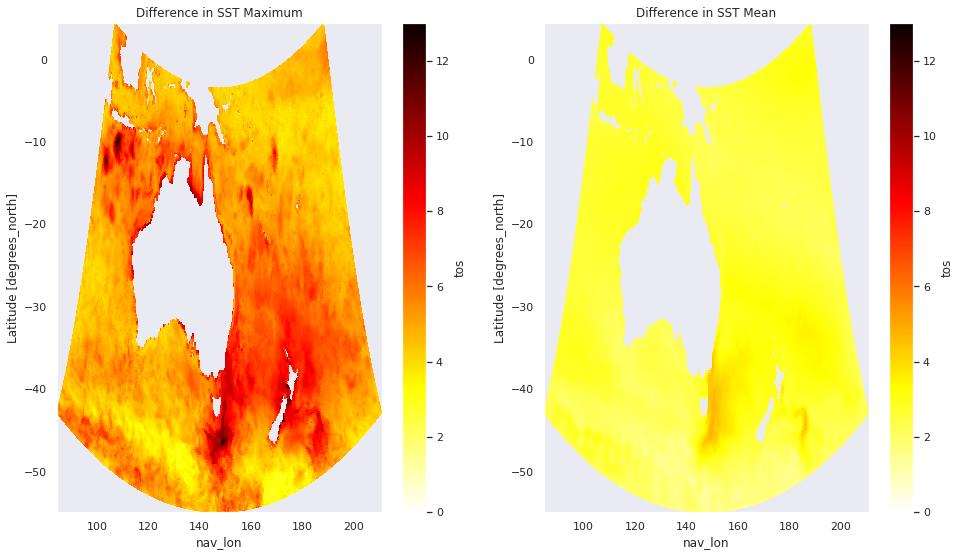

In [32]:
f, (ax1, ax2) = plt.subplots(1,2)
vmin, vmax = (0, 13) 

max_sst_diff.plot(cmap = 'hot_r', vmin = vmin, ax = ax1, x='nav_lon', y ='nav_lat', vmax = vmax)
mean_sst_diff.plot(cmap = 'hot_r', vmin = vmin, ax = ax2, x = 'nav_lon', y = 'nav_lat', vmax = vmax);

ax1.set_title('Difference in SST Maximum')
ax2.set_title('Difference in SST Mean');

## Mixed Layer Depth (MLD) 

In [8]:
mld = mean_file['mld_dt02']

In [82]:
xticks

<function matplotlib.pyplot.xticks(ticks=None, labels=None, **kwargs)>

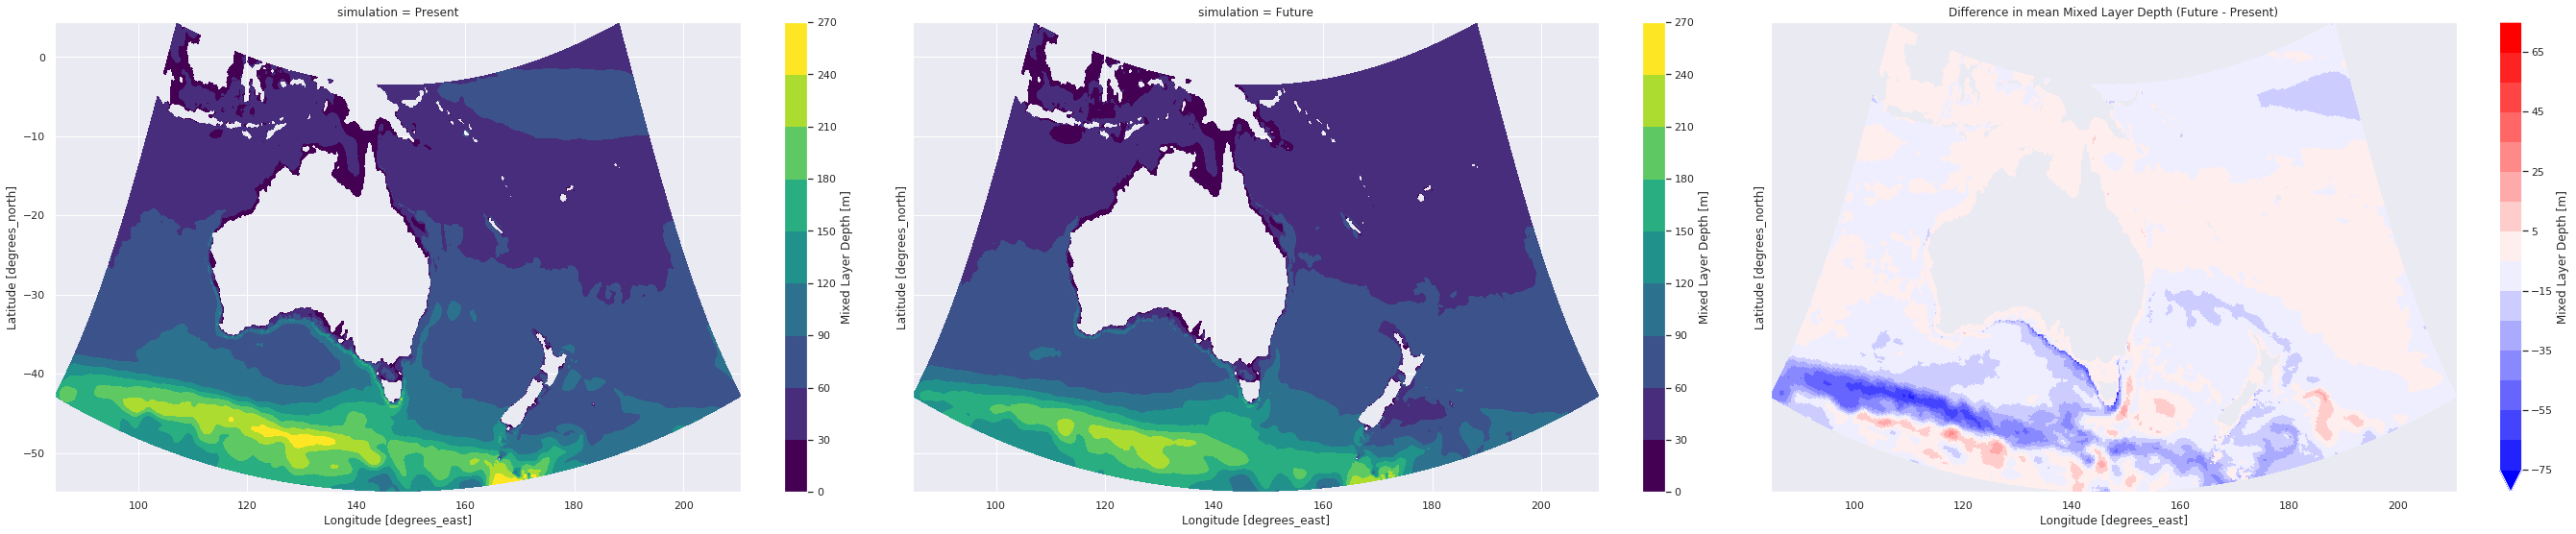

In [347]:
fig, axes = plt.subplots(1,3, figsize = [48,9], sharey = True)
(vmin, vmax) = (0, 270)

levels_diff = linspace(-75, 75, 16)

mld.sel(simulation = 'Present').plot.contourf(x = 'nav_lon', y = 'nav_lat', levels = 10, ax = axes[0], vmin = vmin, vmax = vmax, cbar_kwargs = {'label':'Mixed Layer Depth [m]'});
mld.sel(simulation = 'Future').plot.contourf(x = 'nav_lon', y = 'nav_lat', levels = 10, ax = axes[1], vmin = vmin, vmax = vmax, cbar_kwargs = {'label':'Mixed Layer Depth [m]'});
(mld.sel(simulation = 'Future') - mld.sel(simulation = 'Present')).plot(cmap = cmap_dif, x = 'nav_lon', y = 'nav_lat', levels = levels_diff,
                                                                                 ax = axes[2], cbar_kwargs = {'label':'Mixed Layer Depth [m]'});
fig.subplots_adjust(wspace=0, hspace=0)
axes[2].set_title('Difference in mean Mixed Layer Depth (Future - Present)');
# +ve means past deeper than future, -ve means future deeper than past
# We are expecting increased ocean stratification, so want +ve values
#plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/MLD_diff.png')

In [10]:
mld_seas = seas_file['mld_dt02']

In [11]:
mld_seas_past = mld_seas.sel(simulation = 'Present').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
mld_seas_fut = mld_seas.sel(simulation = 'Future').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
# Changes name of dayofyear coordinates to season names, and changes coordinate name to 'Season'. Also slice away badly simulated bits
mld_seas_past['dayofyear_bins'] = ['Summer', 'Autumn', 'Winter', 'Spring']
mld_seas_past = mld_seas_past.rename({'dayofyear_bins' : 'season'}).isel(x = slice(5,-5), y = slice(5,-50))
mld_seas_fut['dayofyear_bins'] = ['Summer', 'Autumn', 'Winter', 'Spring']
mld_seas_fut = mld_seas_fut.rename({'dayofyear_bins' : 'season'}).isel(x = slice(5,-5), y = slice(5,-50))

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [12]:
mld_seas_diff = mld_seas_fut - mld_seas_past

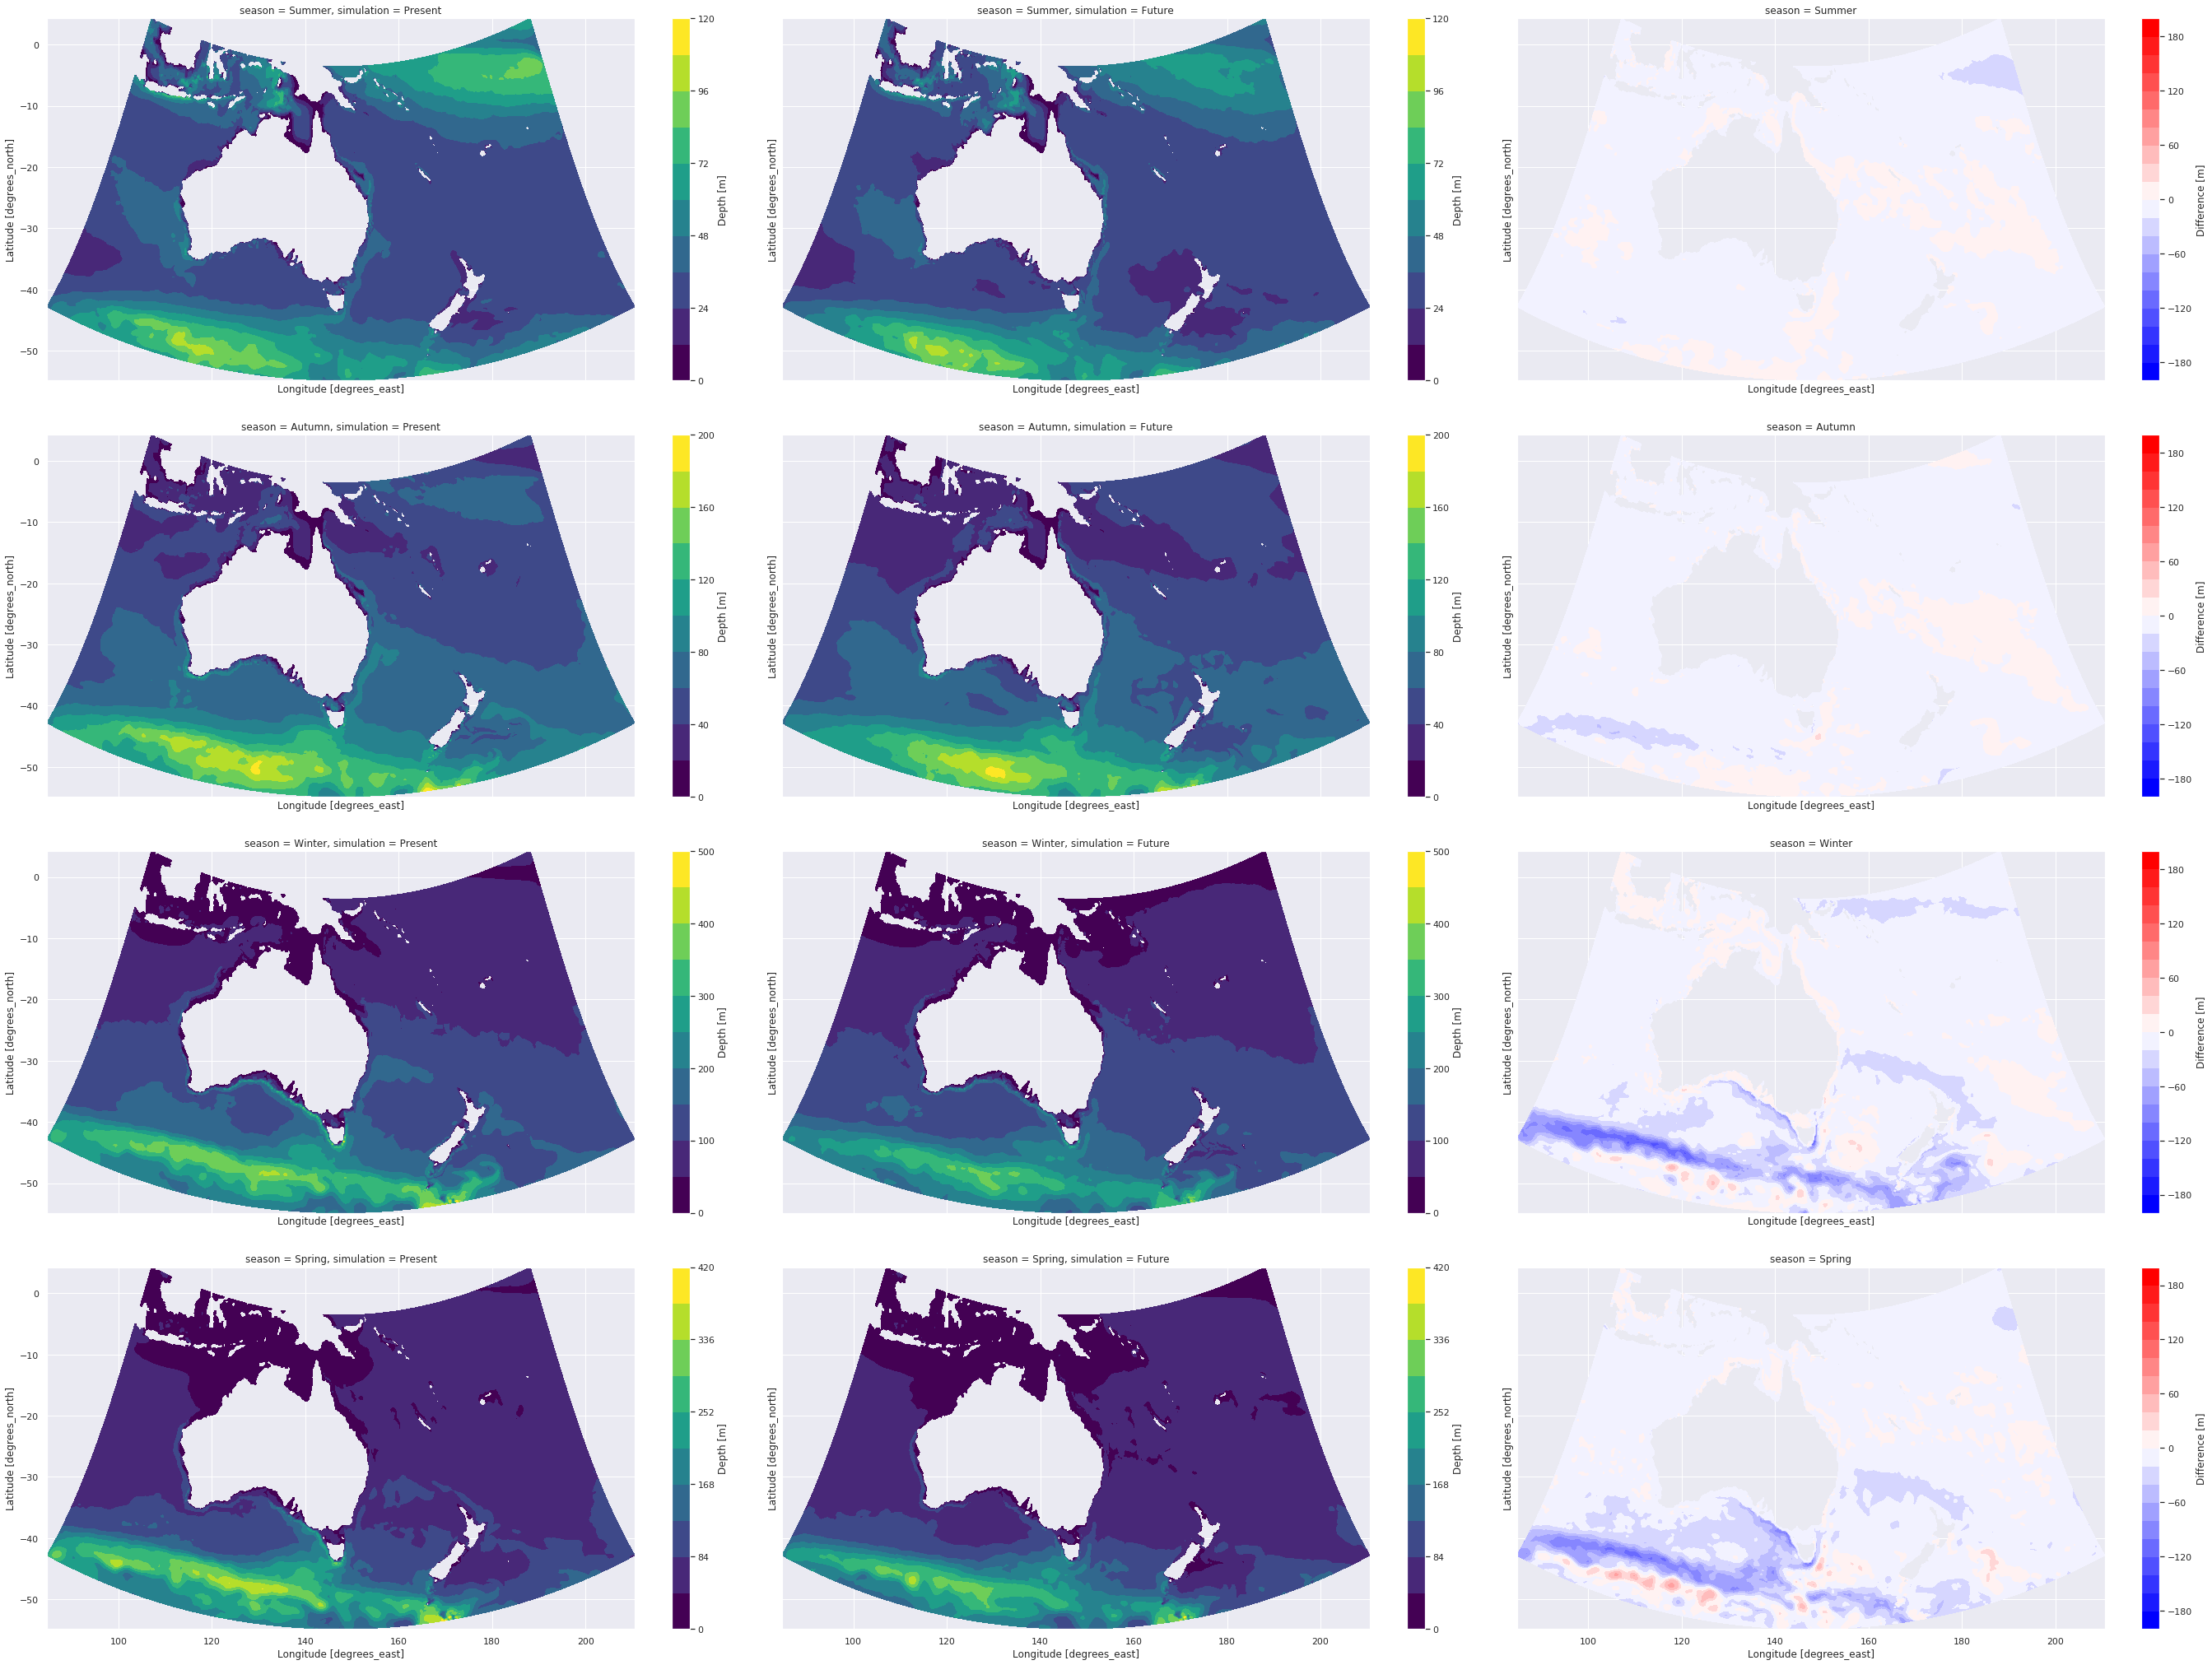

In [26]:
fig, axes = plt.subplots(4,3, sharex = True, sharey = True,figsize = (48, 36))
# Different vmaxs for different seasons
vmax = [120, 200, 500, 420]
vmin1, vmax1 = (-200, 200)
i = 0
for ax in axes:
    mld_seas_past.isel(season = i).plot.contourf(levels = 11, x='nav_lon', y ='nav_lat', ax = ax[0], vmin = 0, vmax = vmax[i], cbar_kwargs = {'label' : 'Depth [m]'});
    mld_seas_fut.isel(season = i).plot.contourf(levels = 11, x='nav_lon', y ='nav_lat', ax = ax[1], vmin = 0, vmax = vmax[i], cbar_kwargs = {'label' : 'Depth [m]'});
    mld_seas_diff.isel(season = i).plot.contourf(levels = 21, cmap = cmap_dif, x='nav_lon', y ='nav_lat', ax = ax[2], vmin = vmin1, vmax = vmax1, cbar_kwargs = {'label' : 'Difference [m]'});
    i += 1 
fig.subplots_adjust(wspace=0, hspace = 0.15)

# Looking for positve values (implies future shallower than past)
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/mld_seasons.png')

## Salinity
Units of psu (equivalent ot g/kg)

In [153]:
sos_seas = seas_file['sos']

In [154]:
sos_seas_past = sos_seas.sel(simulation = 'Present').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
sos_seas_fut = sos_seas.sel(simulation = 'Future').groupby_bins('dayofyear', [-31, 60, 152, 244, 335]).mean('dayofyear').compute()
# Changes name of dayofyear coordinates to season names, and changes coordinate name to 'Season'
sos_seas_past['dayofyear_bins'] = ['Summer', 'Autumn', 'Winter', 'Spring']
sos_seas_past = sos_seas_past.rename({'dayofyear_bins' : 'season'}).isel(x = slice(5,-5), y = slice(5,-50))
sos_seas_fut['dayofyear_bins'] = ['Summer', 'Autumn', 'Winter', 'Spring']
sos_seas_fut = sos_seas_fut.rename({'dayofyear_bins' : 'season'}).isel(x = slice(5,-5), y = slice(5,-50))

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [155]:
sos_seas_diff = sos_seas_fut - sos_seas_past

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: divide by zero encountered in true_divide
  x = np.divide(x1, x2, out)
/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


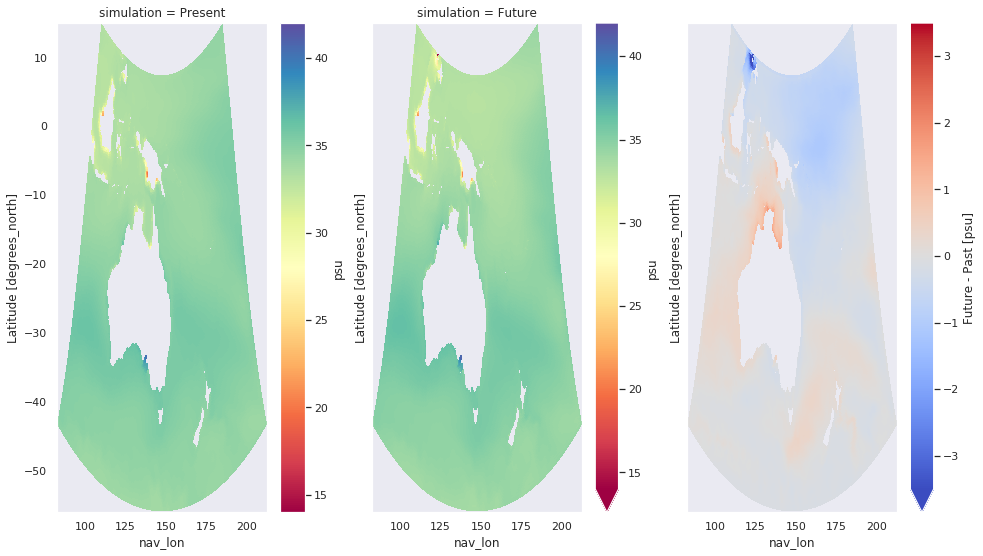

In [176]:
f, ax = plt.subplots(1,3, sharey = True, figsize = (48, 9))
sos_ave_past = sos_seas.sel(simulation = 'Present').mean('dayofyear') 
sos_ave_fut = sos_seas.sel(simulation = 'Future').mean('dayofyear') 
sos_ave_diff = sos_ave_fut - sos_ave_past

sos_ave_past.plot(x='nav_lon', y ='nav_lat', ax = ax[0], vmin = 14, vmax = 42, cbar_kwargs = {'label' : 'psu'}, cmap = 'Spectral')
sos_ave_fut.plot(x='nav_lon', y ='nav_lat', ax = ax[1], vmin = 14, vmax = 42, cbar_kwargs = {'label' : 'psu'}, cmap = 'Spectral')
sos_ave_diff.plot(cmap = 'coolwarm', x='nav_lon', y ='nav_lat', vmin = vmin1, vmax = vmax1, ax = ax[2], cbar_kwargs = {'label' : 'Future - Past [psu]'});

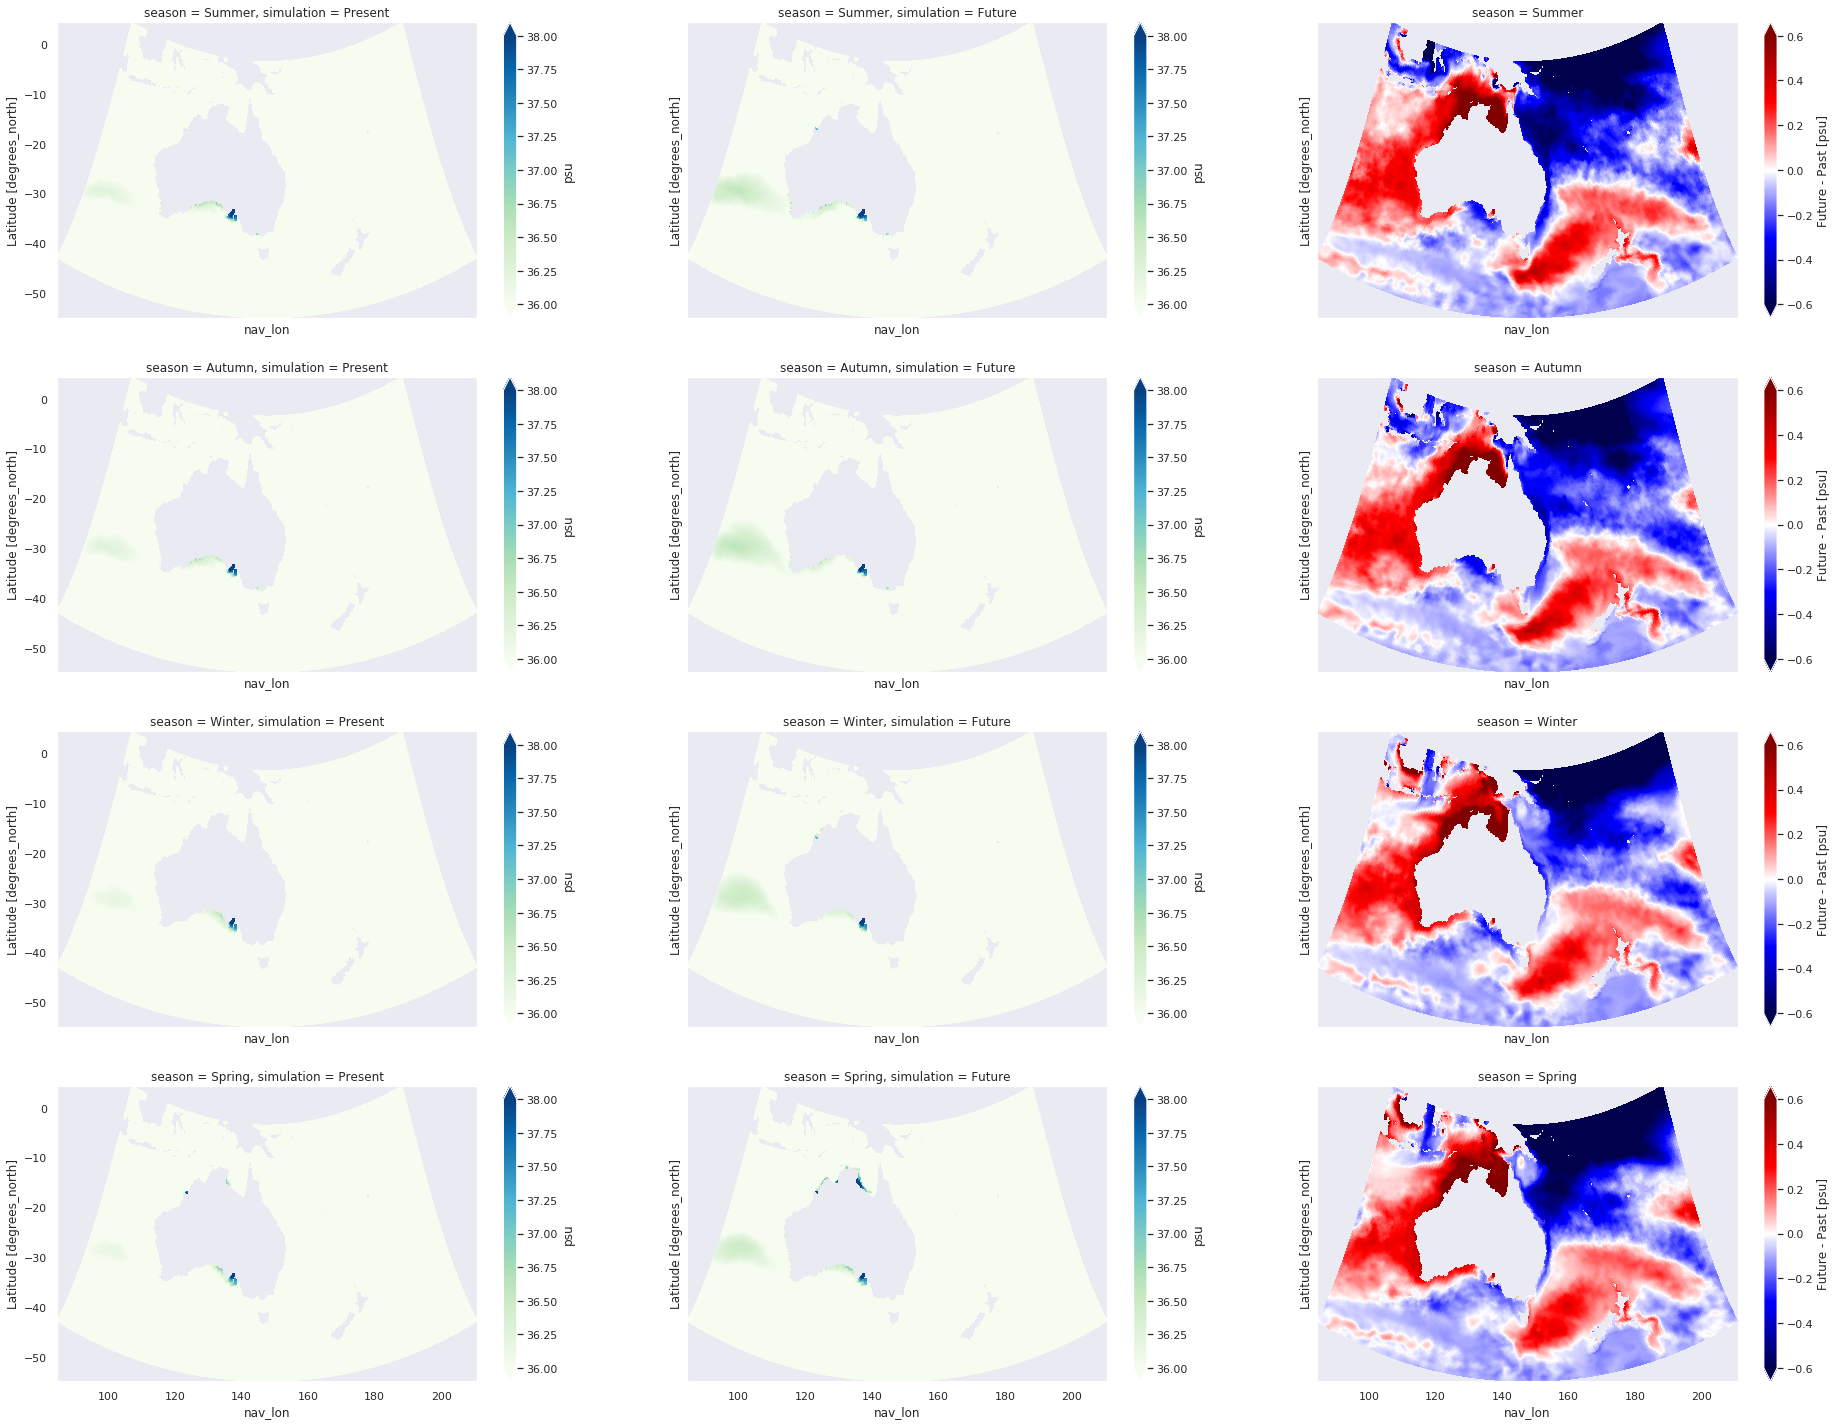

In [200]:
f, axes = plt.subplots(4,3, sharex = True, sharey = True,figsize = (32, 25))
# Different vmaxs for different seasons
vmin1, vmax1 = (-0.6, 0.6)
i = 0
for ax in axes:
    sos_seas_past.isel(season = i).plot(x='nav_lon', y ='nav_lat', ax = ax[0], vmin = 36, vmax = 38, cbar_kwargs = {'label' : 'psu'}, cmap = 'GnBu');
    sos_seas_fut.isel(season = i).plot(x='nav_lon', y ='nav_lat', ax = ax[1], vmin = 36, vmax = 38, cbar_kwargs = {'label' : 'psu'}, cmap = 'GnBu');
    sos_seas_diff.isel(season = i).plot(cmap = cmap_dif, x='nav_lon', y ='nav_lat', vmin = vmin1, vmax = vmax1, ax = ax[2], cbar_kwargs = {'label' : 'Future - Past [psu]'});
    # Need to perform a t-test for each season - not sure how to do it right now
    i += 1 
    
# Looking for positve values (implies future shallower than past)
# Need to superimpose t-test values over the difference plot before saving it. ALmost there!
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/sos_seasons.png')

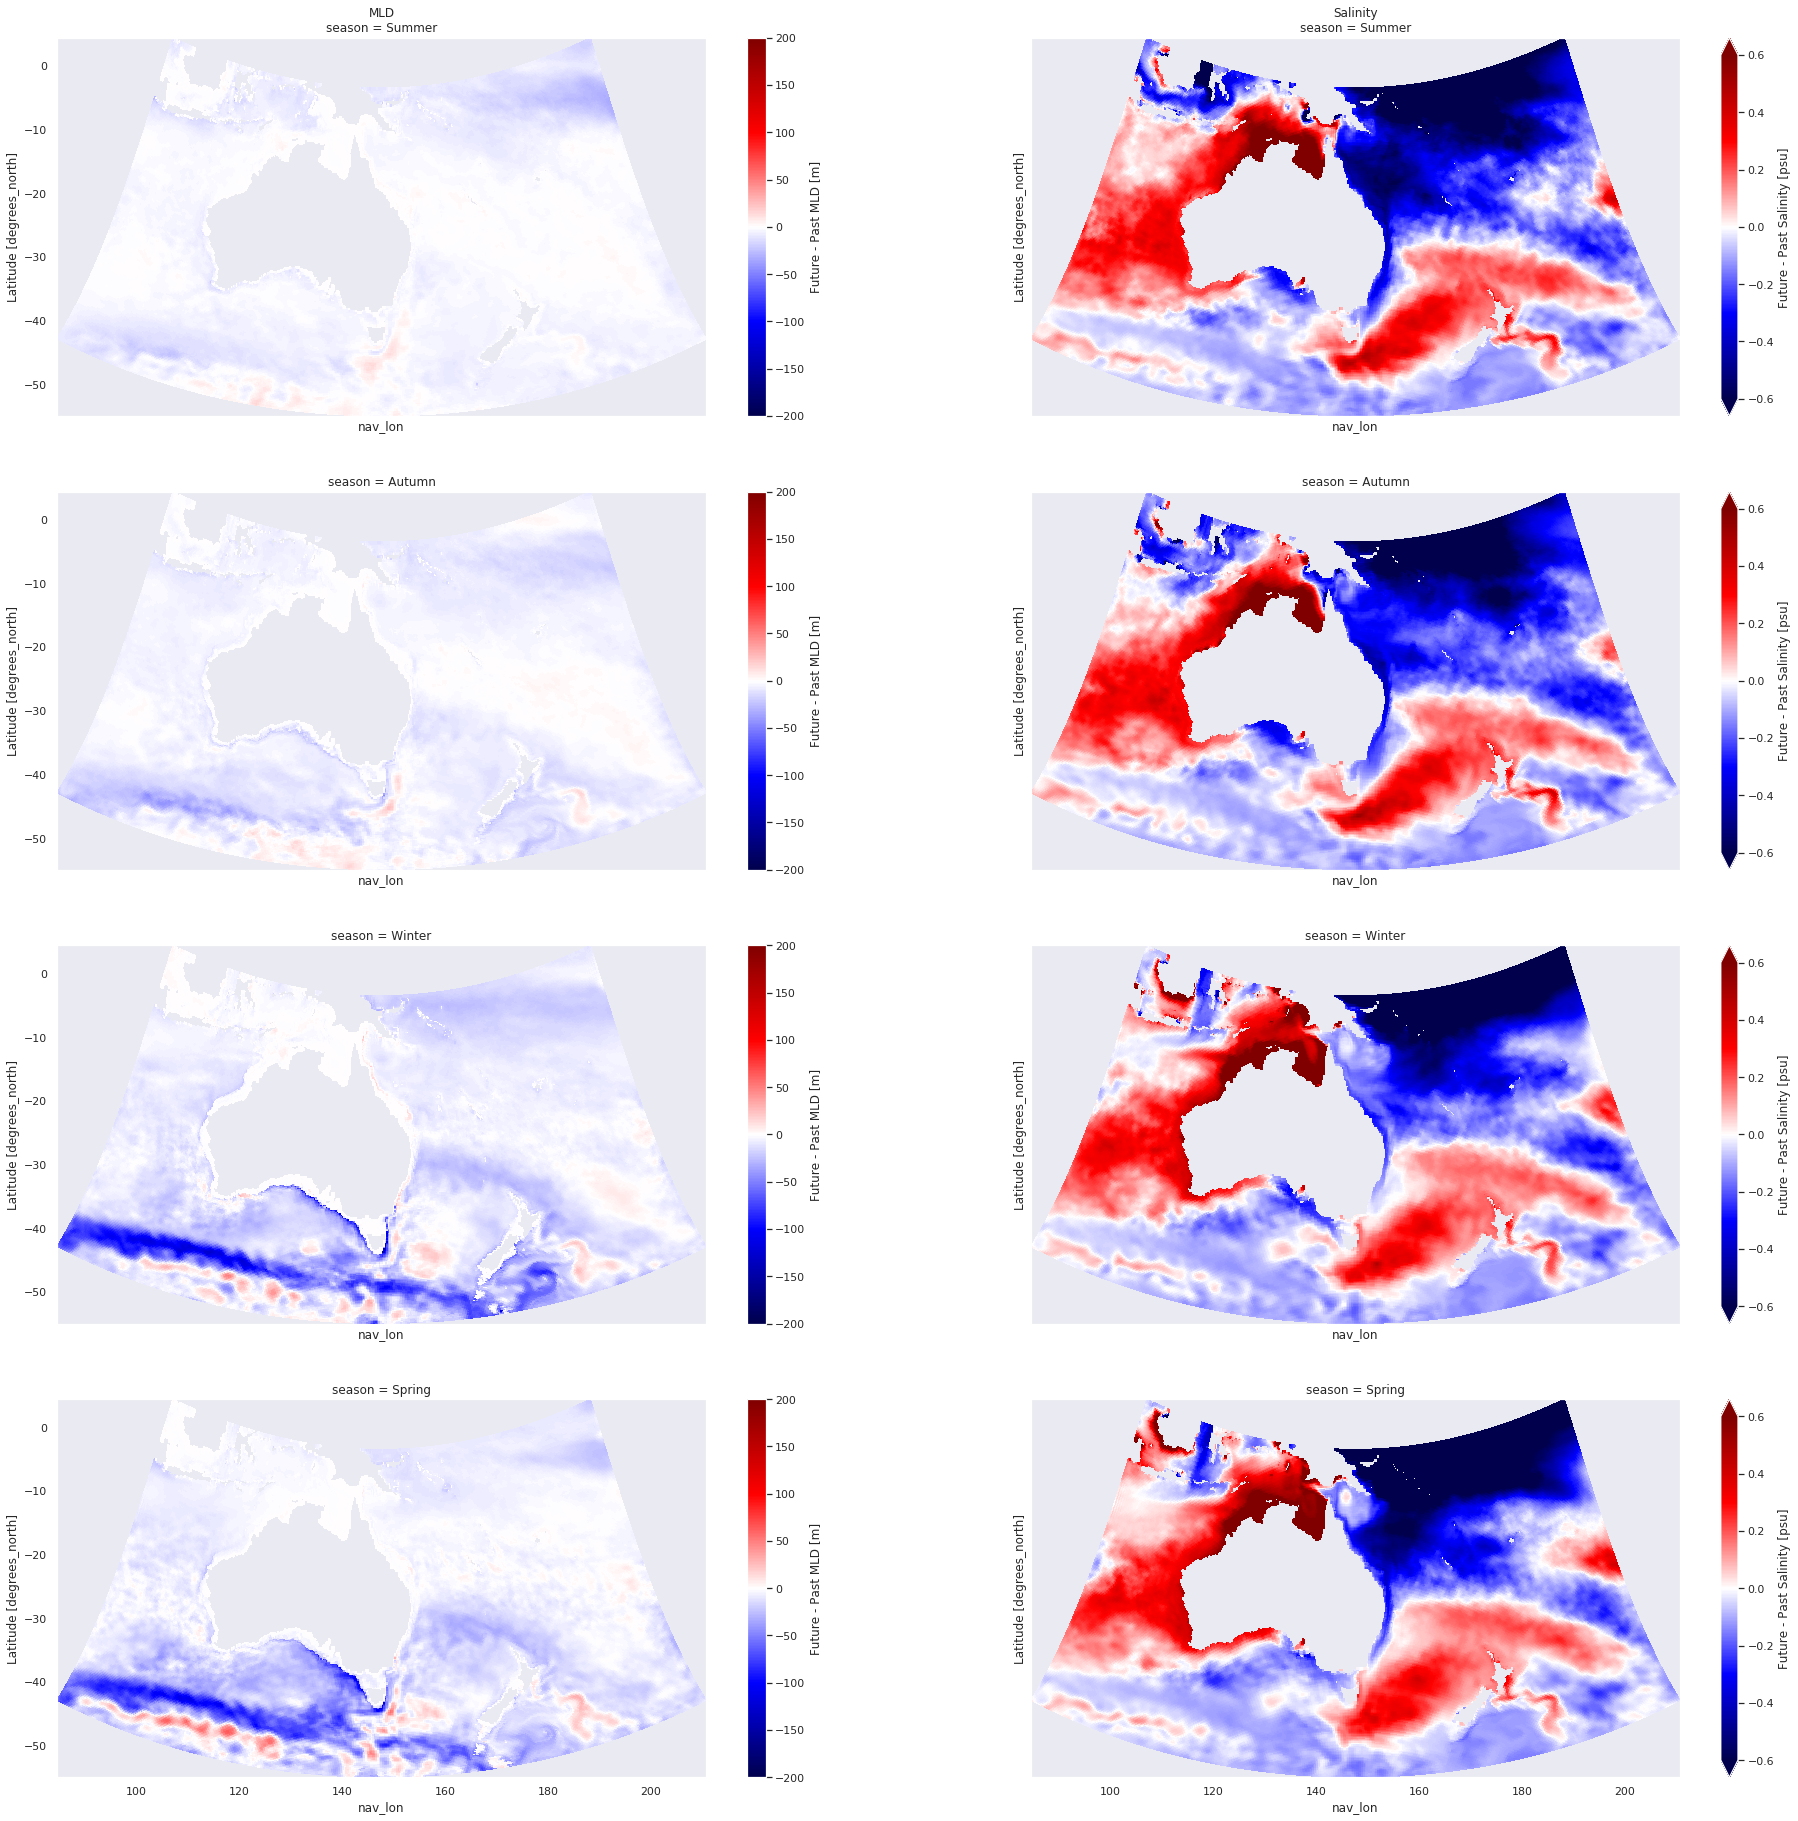

In [204]:
# Plotting MLD and salinity together
f, axes = plt.subplots(4,2, sharex = True, sharey = True,figsize = (32, 32))
# Different vmaxs for different seasons
vmin1, vmax1 = (-0.6, 0.6)
i = 0
for ax in axes:
    mld_seas_diff.isel(season = i).plot(cmap = cmap_dif, x='nav_lon', y ='nav_lat', vmin = -200, vmax = 200, ax = ax[0], cbar_kwargs = {'label' : 'Future - Past MLD [m]'});
    sos_seas_diff.isel(season = i).plot(cmap = cmap_dif, x='nav_lon', y ='nav_lat', vmin = vmin1, vmax = vmax1, ax = ax[1], cbar_kwargs = {'label' : 'Future - Past Salinity [psu]'});
    i += 1 
    
axes[0,0].set_title('MLD\nseason = Summer')
axes[0,1].set_title('Salinity\nseason = Summer')
plt.savefig('/home/561/rm6294/Documents/Statistics_Plots/mld_sos_comparison.png')

## Winds
units = $m/s$

In [27]:
# Opens wind speeds and removes troublesome areas
u = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_U_2D_mean.nc')['uos'].isel(x = slice(5,-5), y = slice(5,-50))
v = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_grid_V_2D_mean.nc')['vos'].isel(x = slice(5,-5), y = slice(5,-50))

In [33]:
# Makes plotting easier
for i in (u,v):
    i['nav_lon'] = i['nav_lon'] % 360  
    i['nav_lon'].attrs['units'] = 'degrees_east'
    i['nav_lon'].attrs['long_name'] = 'Longitude'
    i['nav_lon'].attrs['standard_name'] = 'longitude'

In [34]:
udif = u.sel(simulation = 'Future') - u.sel(simulation = 'Present') 
vdif = v.sel(simulation = 'Future') - v.sel(simulation = 'Present') 

In [35]:
U = da.array.sqrt(udif ** 2 + vdif ** 2)

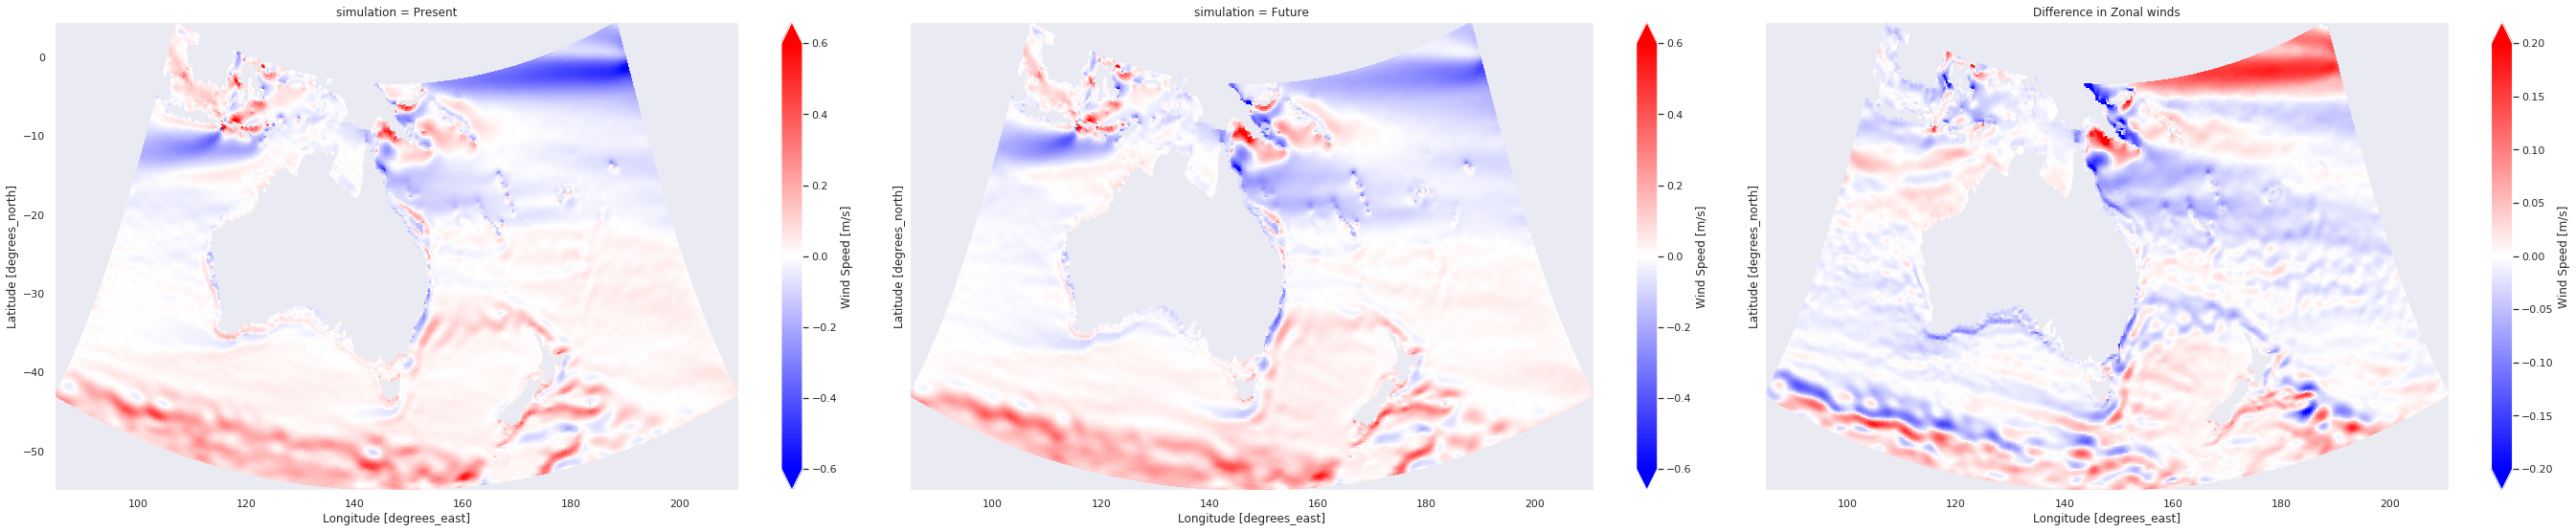

In [139]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = [48, 9])
vmin, vmax = (-0.6, 0.6)
vmin1, vmax1 = (-0.2, 0.2)
u.sel(simulation = 'Present').plot(x='nav_lon', y ='nav_lat', ax = ax[0], cbar_kwargs = {'label' : 'Wind Speed [m/s]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
u.sel(simulation = 'Future').plot(x='nav_lon', y ='nav_lat', ax = ax[1], cbar_kwargs = {'label' : 'Wind Speed [m/s]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
udif.plot(x='nav_lon', y ='nav_lat', ax = ax[2], cbar_kwargs = {'label' : 'Wind Speed [m/s]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
fig.subplots_adjust(wspace=0, hspace = 0.15)

ax[2].set_title('Difference in Zonal winds');
plt.savefig('/home/561/rm6294/Documents/Winds/mean_zonal.png')

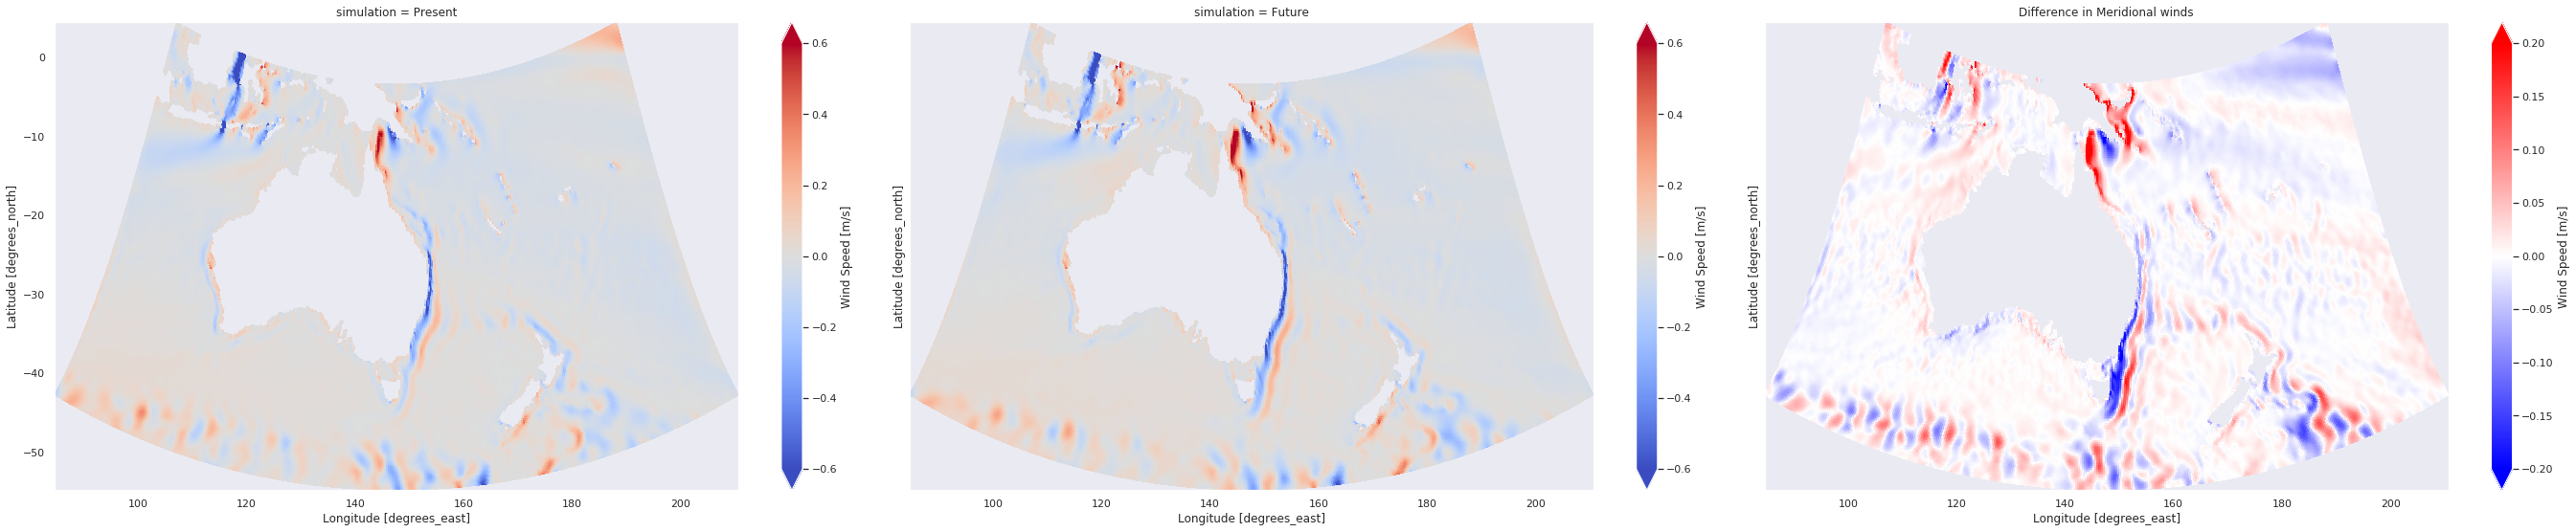

In [43]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = [48, 9])
vmin, vmax = (-0.6, 0.6)
vmin1, vmax1 = (-0.2, 0.2)
v.sel(simulation = 'Present').plot(x='nav_lon', y ='nav_lat', ax = ax[0], cbar_kwargs = {'label' : 'Wind Speed [m/s]'}, vmin= vmin, vmax = vmax, cmap = 'coolwarm')
v.sel(simulation = 'Future').plot(x='nav_lon', y ='nav_lat', ax = ax[1], cbar_kwargs = {'label' : 'Wind Speed [m/s]'}, vmin = vmin, vmax = vmax, cmap = 'coolwarm')
vdif.plot(x='nav_lon', y ='nav_lat', ax = ax[2], cbar_kwargs = {'label' : 'Wind Speed [m/s]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
fig.subplots_adjust(wspace=0, hspace = 0.15)

ax[2].set_title('Difference in Meridional winds');
#plt.savefig('/home/561/rm6294/Documents/Winds/mean_meriodinal.png')

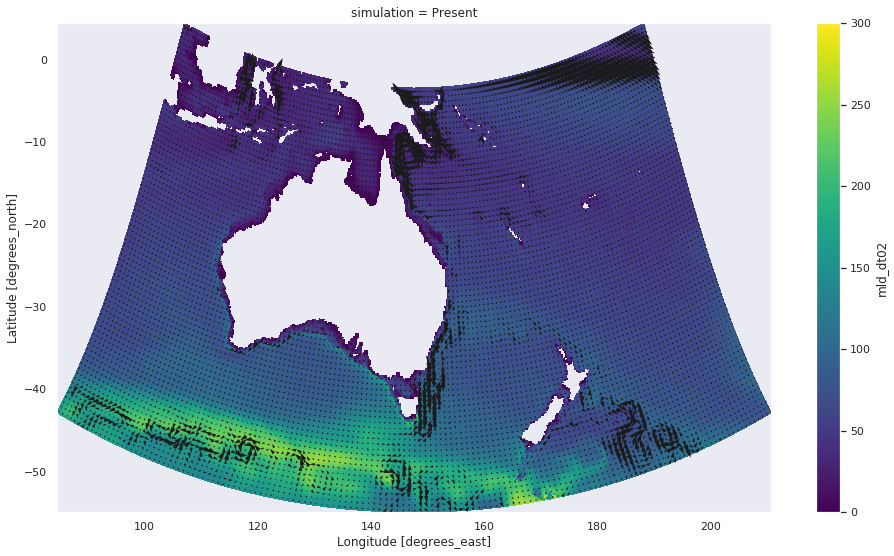

In [49]:
fig, ax = plt.subplots()
mld.sel(simulation = 'Present').plot(x = 'nav_lon', y = 'nav_lat', vmin = 0, vmax = 300, ax = ax);
skip = 3
ax.quiver(udif['nav_lon'][::skip, ::skip], vdif['nav_lat'][::skip, ::skip], udif[::skip, ::skip], vdif[::skip, ::skip], pivot='middle', angles='xy', scale_units='xy',  scale = 0.1);
#plt.xlim(140); plt.ylim(-55,-10);
#ax.set_aspect('equal')
#plt.title('Wind');
#plt.savefig('/home/561/rm6294/Documents/Winds/wind_direction_every3.png')

## Heat Flux

In [531]:
#hf = heat flux. Made up of adv, shf and residual. As we have taken a time average adv + shf + res=0 => res === shf + adv 
hf = xr.open_dataset(mean_dir + 'ECL_NEMO_1990-2008_1d_SST_budget.nc').isel(x = slice(5,-5), y = slice(5,-50))
hf['nav_lon'] = hf['nav_lon'] % 360
hf['nav_lon'].attrs['units'] = 'degrees_east'
hf['nav_lon'].attrs['long_name'] = 'Longitude'
hf['nav_lon'].attrs['standard_name'] = 'longitude'

# hf has been scaled by cp and rho (density). Unscaling this so that graphs can be more easily understood
cp = 4186 # J/kg
rho = 1024 # kg/m^3 - Not sure at what temparture/ This is right to ~2sf

hf = hf * cp * rho

In [532]:
# adv = advection (horizontal). Calculated by summing up the multiple seperate advection terms
a = ['mhf_geo', 'mhf_ageo', 'ehf_ageo']
adv = -1*hf['ehf_geo']
for i in a:
    adv -= hf[i]
adv = adv.rename('adv')

In [533]:
#shf = surface heat flux, res = residual
shf = hf['shf']
res = hf['residual']

In [534]:
adv_diff = adv.sel(simulation = 'Future') - adv.sel(simulation = 'Present')
shf_diff = shf.sel(simulation = 'Future') - shf.sel(simulation = 'Present')
res_diff = res.sel(simulation = 'Future') - res.sel(simulation = 'Present')

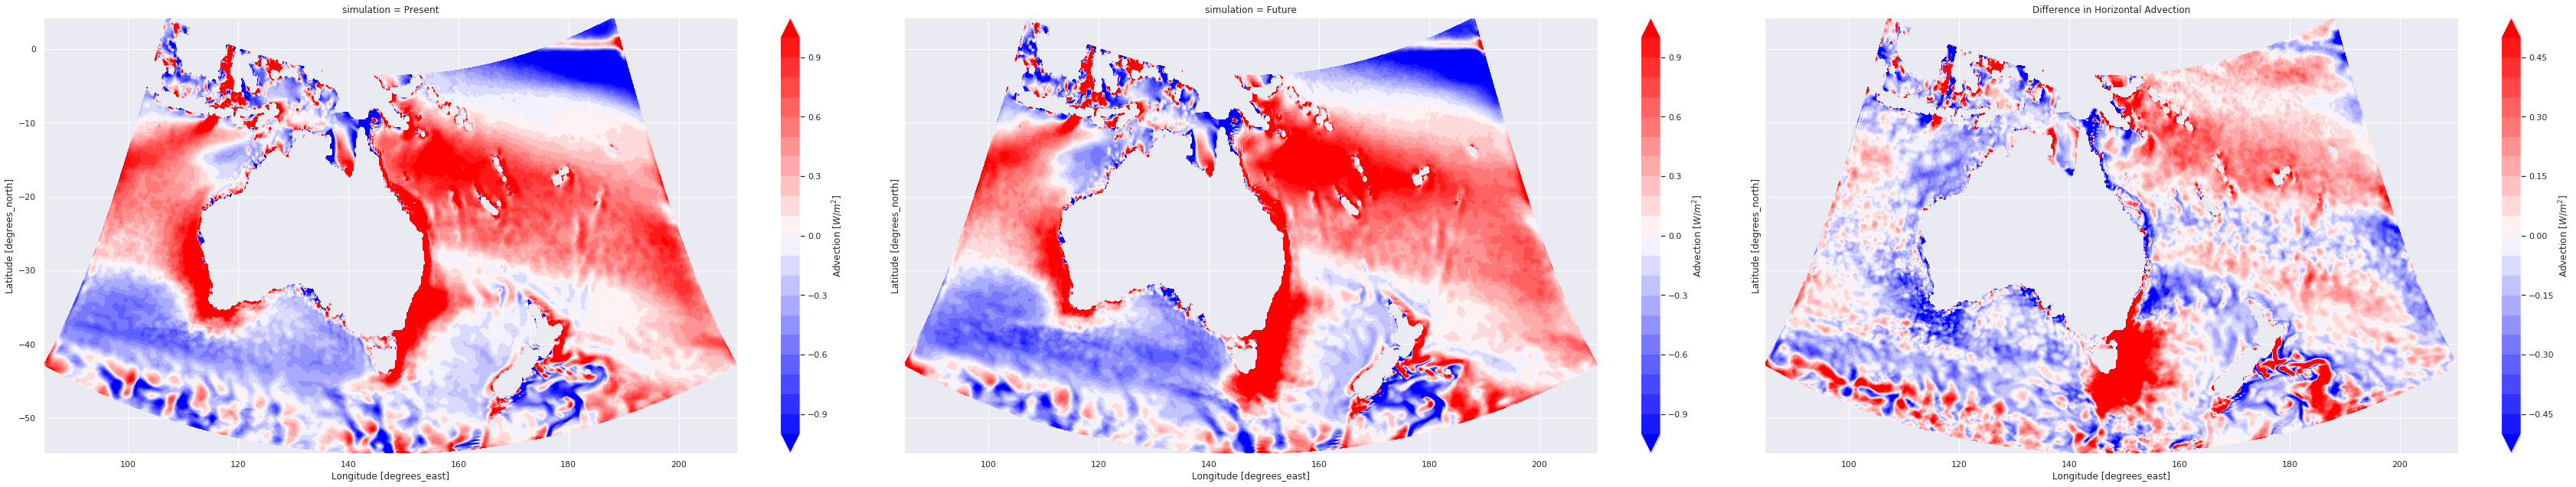

In [561]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = [48, 9])
vmin, vmax = (-1,1)
vmin1, vmax1 = (-0.5, 0.5)
num_levels = 21
adv.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0], 
                                     cbar_kwargs = {'label' : 'Advection [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
adv.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1],
                                             cbar_kwargs = {'label' : 'Advection [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
adv_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2], 
                       cbar_kwargs = {'label' : 'Advection [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
fig.tight_layout()
ax[2].set_title('Difference in Horizontal Advection');

plt.savefig('/home/561/rm6294/Documents/Heat_Flux/advection.png')

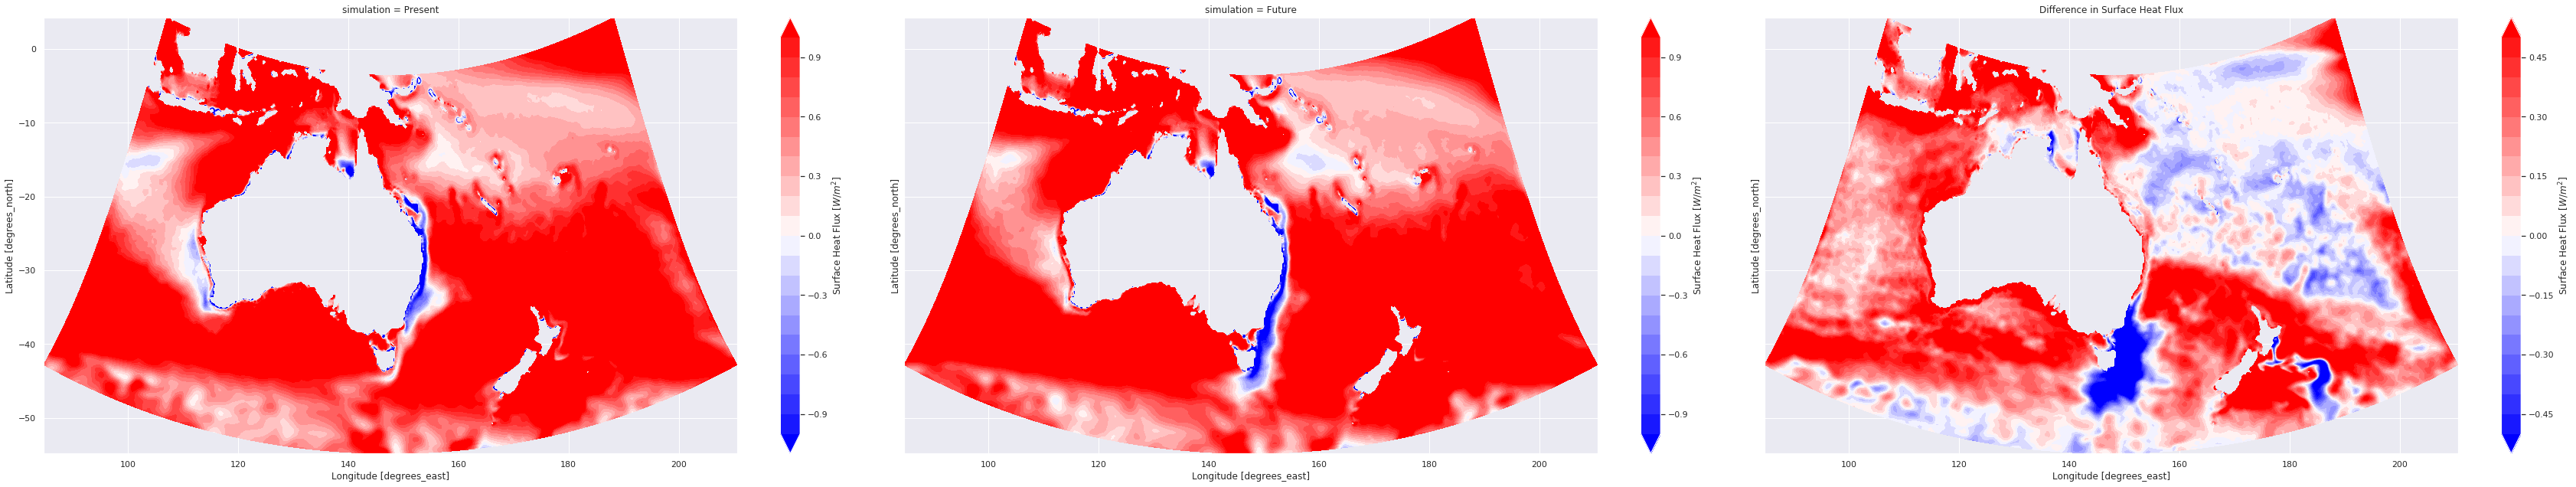

In [562]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = [48, 9])
vmin, vmax = (-1,1)
vmin1, vmax1 = (-0.5, 0.5)
num_levels = 21
shf.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0], 
                                     cbar_kwargs = {'label' : 'Surface Heat Flux [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
shf.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1],
                                             cbar_kwargs = {'label' : 'Surface Heat Flux [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
shf_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2], 
                       cbar_kwargs = {'label' : 'Surface Heat Flux [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
fig.tight_layout()
ax[2].set_title('Difference in Surface Heat Flux');
plt.savefig('/home/561/rm6294/Documents/Heat_Flux/air_sea_hf.png')

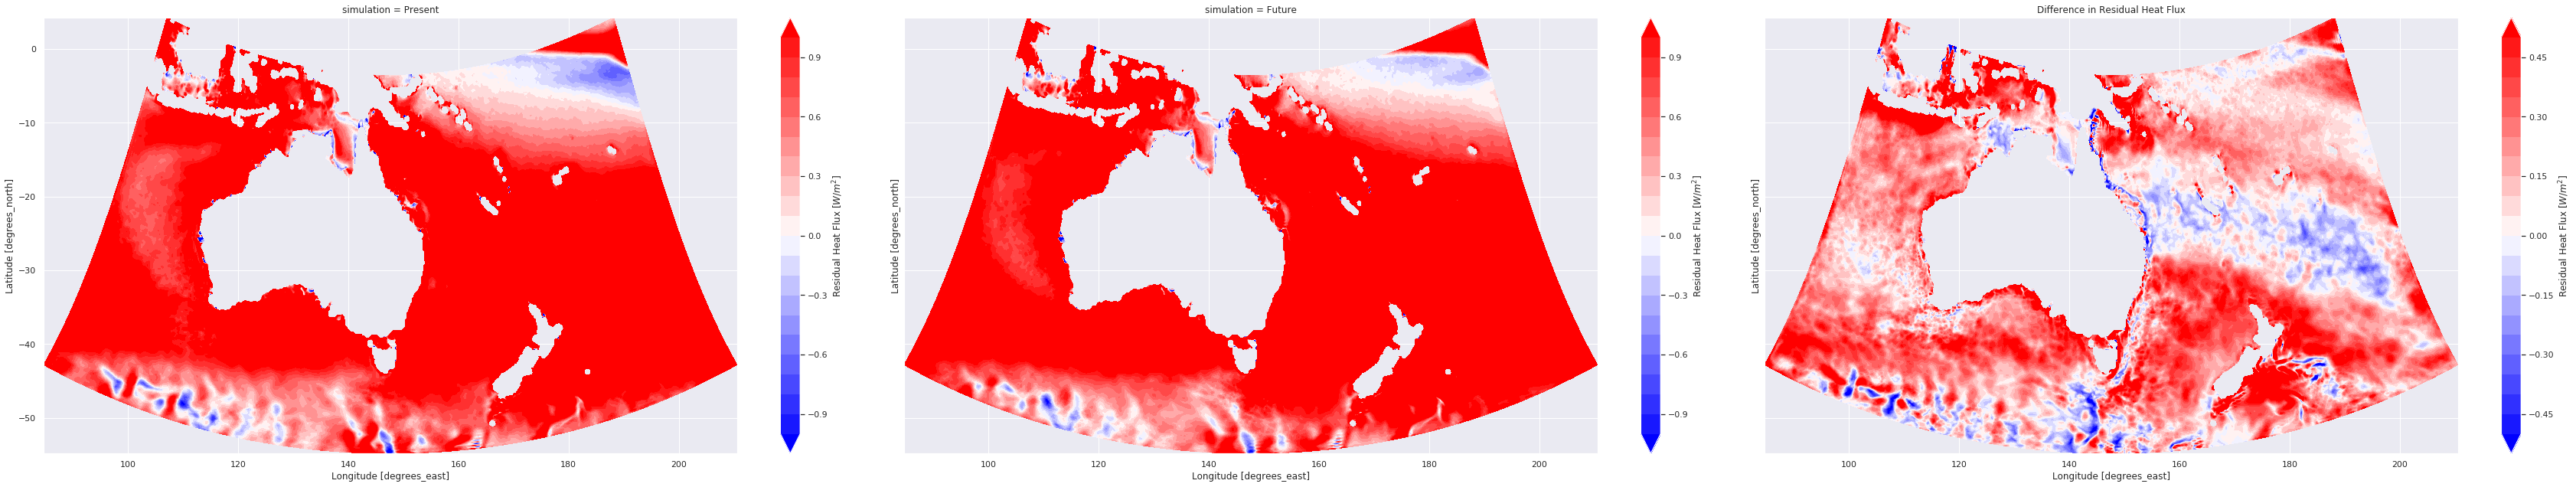

In [563]:
fig, ax = plt.subplots(1,3, sharey = True, figsize = [48, 9])
vmin, vmax = (-1,1)
vmin1, vmax1 = (-0.5, 0.5)
num_levels = 21
res.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0], 
                                     cbar_kwargs = {'label' : 'Residual Heat Flux [$W/m^2]$'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
res.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1],
                                             cbar_kwargs = {'label' : 'Residual Heat Flux [$W/m^2]$'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
res_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2], 
                       cbar_kwargs = {'label' : 'Residual Heat Flux [$W/m^2]$'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
fig.tight_layout()

ax[2].set_title('Difference in Residual Heat Flux');
plt.savefig('/home/561/rm6294/Documents/Heat_Flux/residual.png')

In [277]:
from matplotlib.transforms import offset_copy

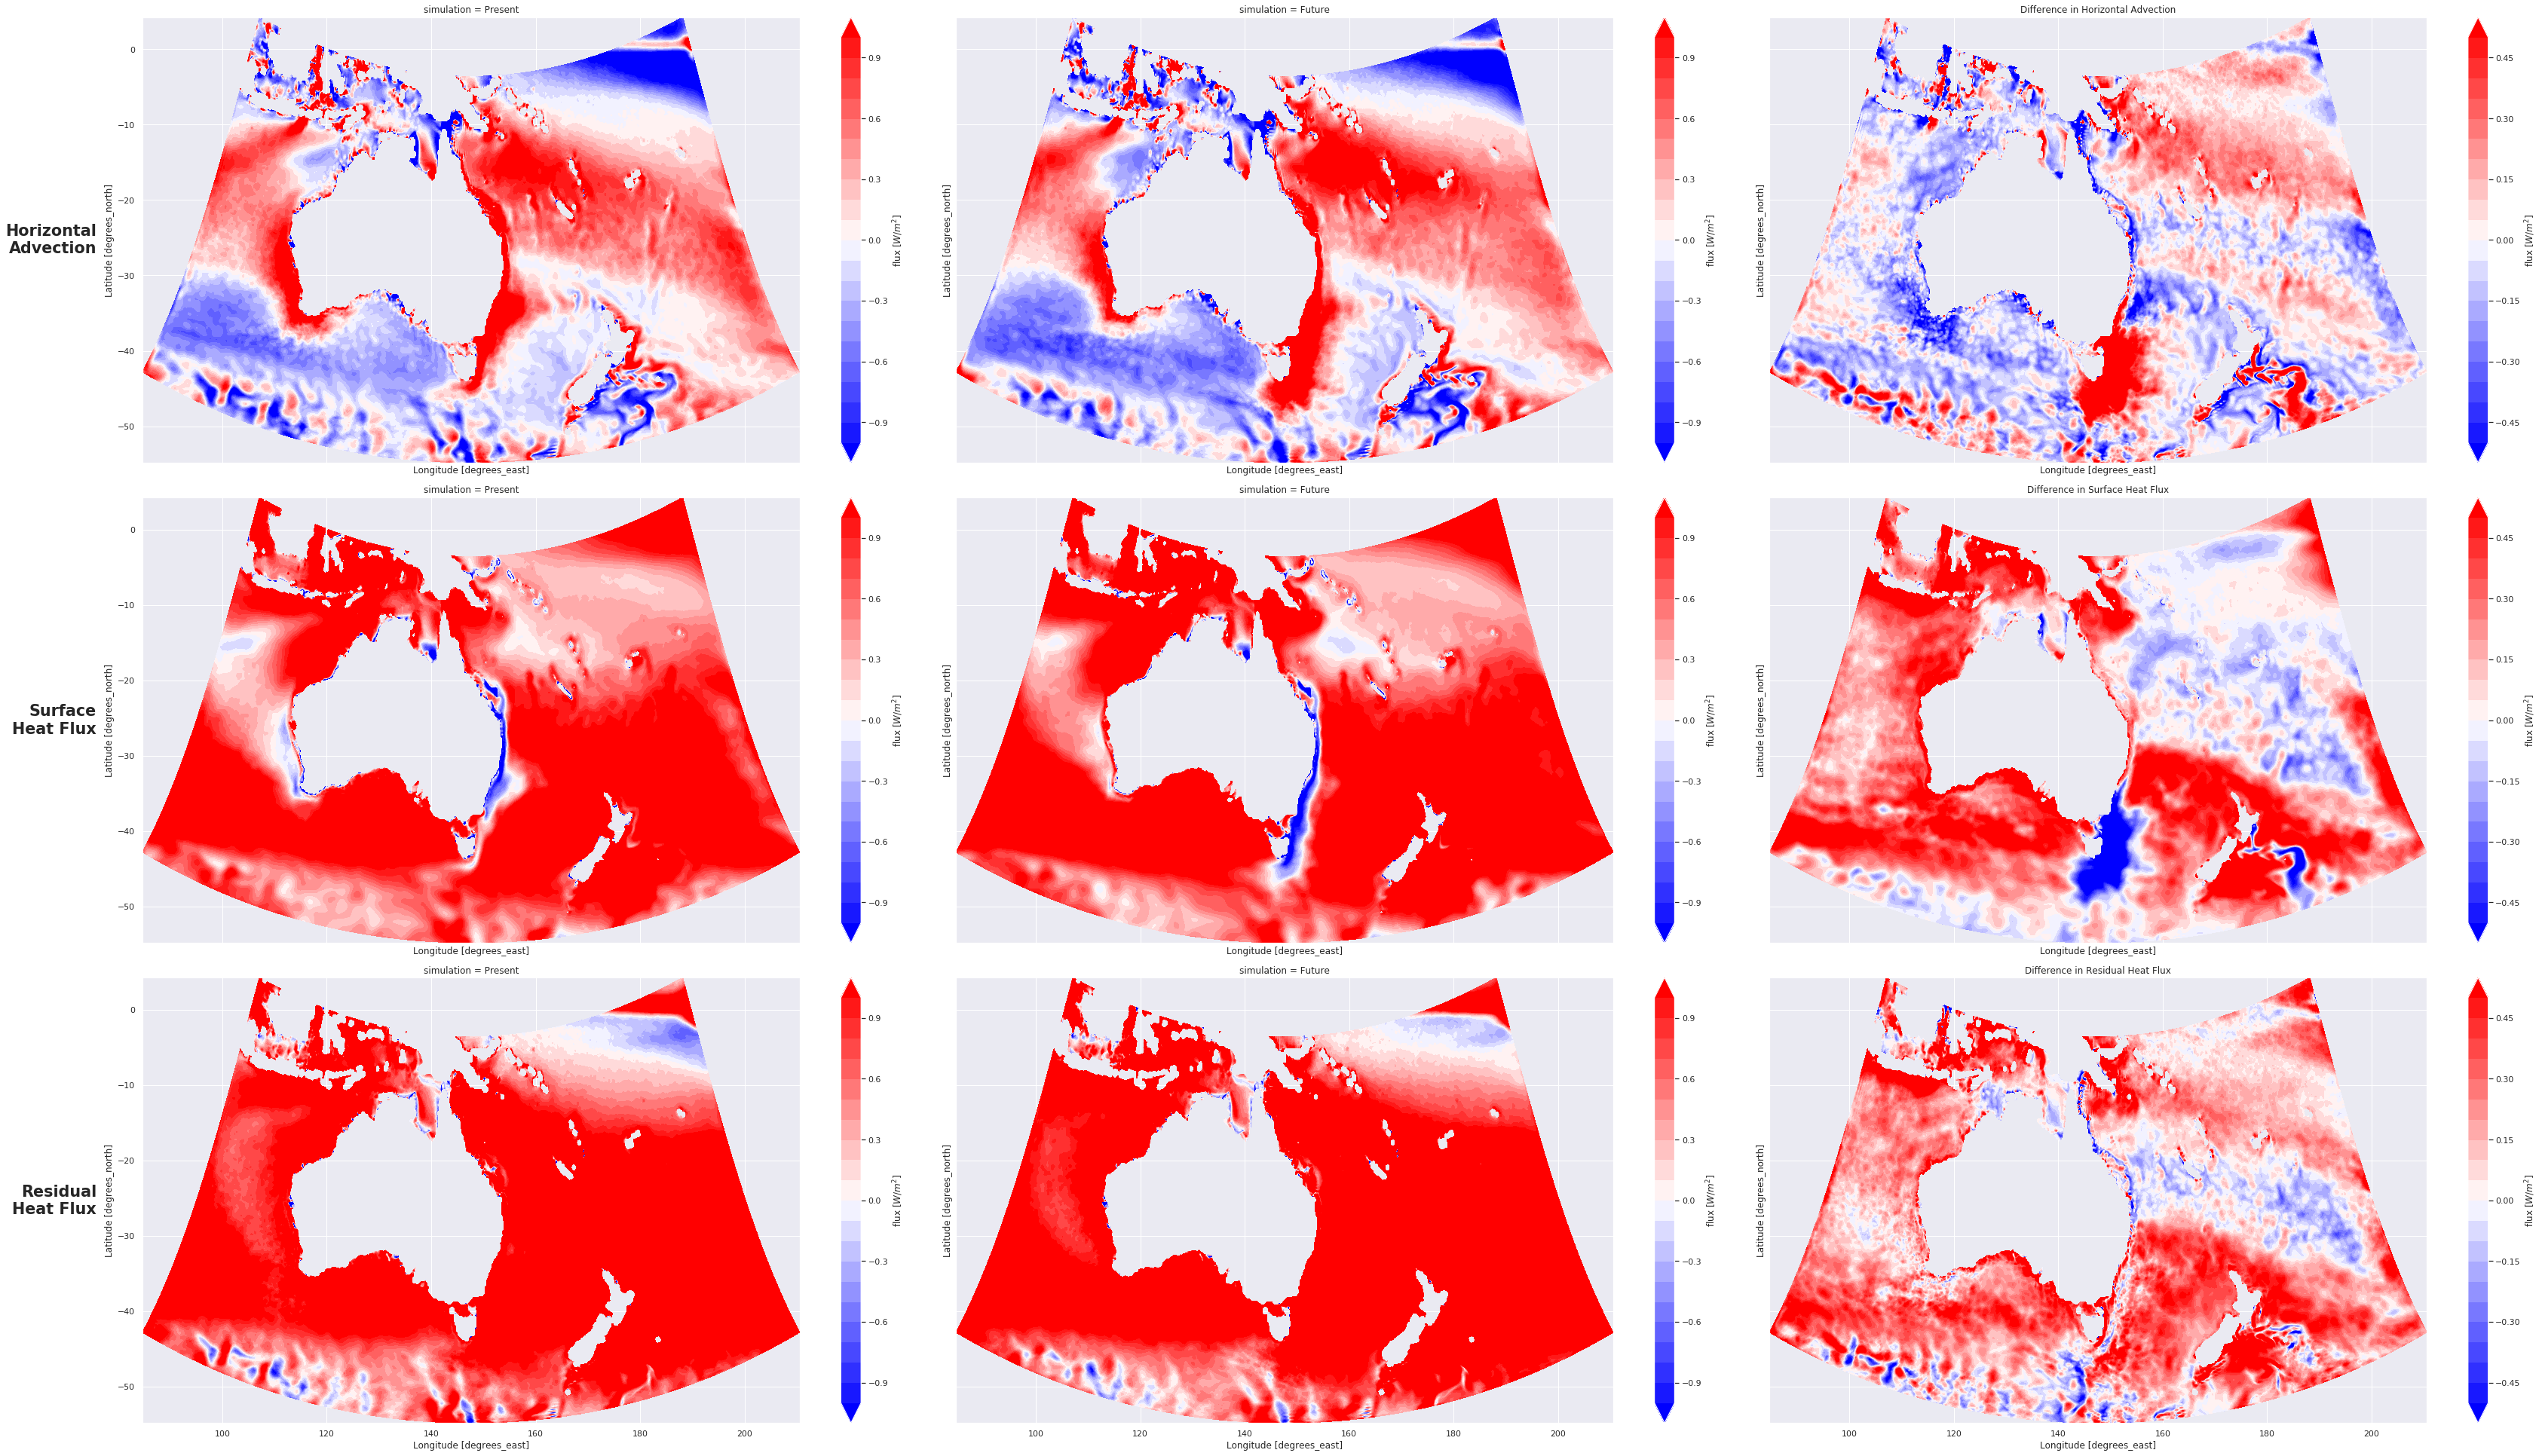

In [565]:
# All together now
fig, ax = plt.subplots(3,3, sharey = True, sharex = True, figsize = [48, 27])
vmin, vmax = (-1,1)
vmin1, vmax1 = (-0.5, 0.5)
num_levels = 21

adv.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0,0], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
adv.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0,1],cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
adv_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0,2], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
ax[0,2].set_title('Difference in Horizontal Advection');

shf.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1,0], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
shf.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1,1],cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
shf_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1,2], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
ax[1,2].set_title('Difference in Surface Heat Flux');

res.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2,0], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
res.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2,1],cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
res_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2,2], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
ax[2,2].set_title('Difference in Residual Heat Flux');

rows = ['Horizontal\nAdvection', 'Surface\nHeat Flux', 'Residual\nHeat Flux']
pad = 7

for axes, row in zip(ax[:,0], rows):
    axes.annotate(row, xy=(0, 0.5), xytext=(-axes.yaxis.labelpad - pad, 0),xycoords=axes.yaxis.label, textcoords='offset points',
                size='xx-large', ha='right', va='center', fontweight = 'bold')

fig.tight_layout()

plt.savefig('/home/561/rm6294/Documents/Heat_Flux/all3.png')

#### Comparing Eddy and Mean Transport

In [571]:
# Calculating the contribution to heat flux from only the eddy terms
ehf = hf['ehf_geo'] + hf['ehf_ageo']
#ehf = ehf/adv
ehf_diff = ehf.sel(simulation = 'Future') - ehf.sel(simulation = 'Present')

# Calculating the contribution to heat flux from only the mean terms
mhf = hf['mhf_geo'] + hf['mhf_ageo']
#mhf = mhf/adv
mhf_diff = mhf.sel(simulation = 'Future') - mhf.sel(simulation = 'Present')

/g/data1/e14/rm6294/miniconda3/envs/now-postprocess/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'title'
  s)


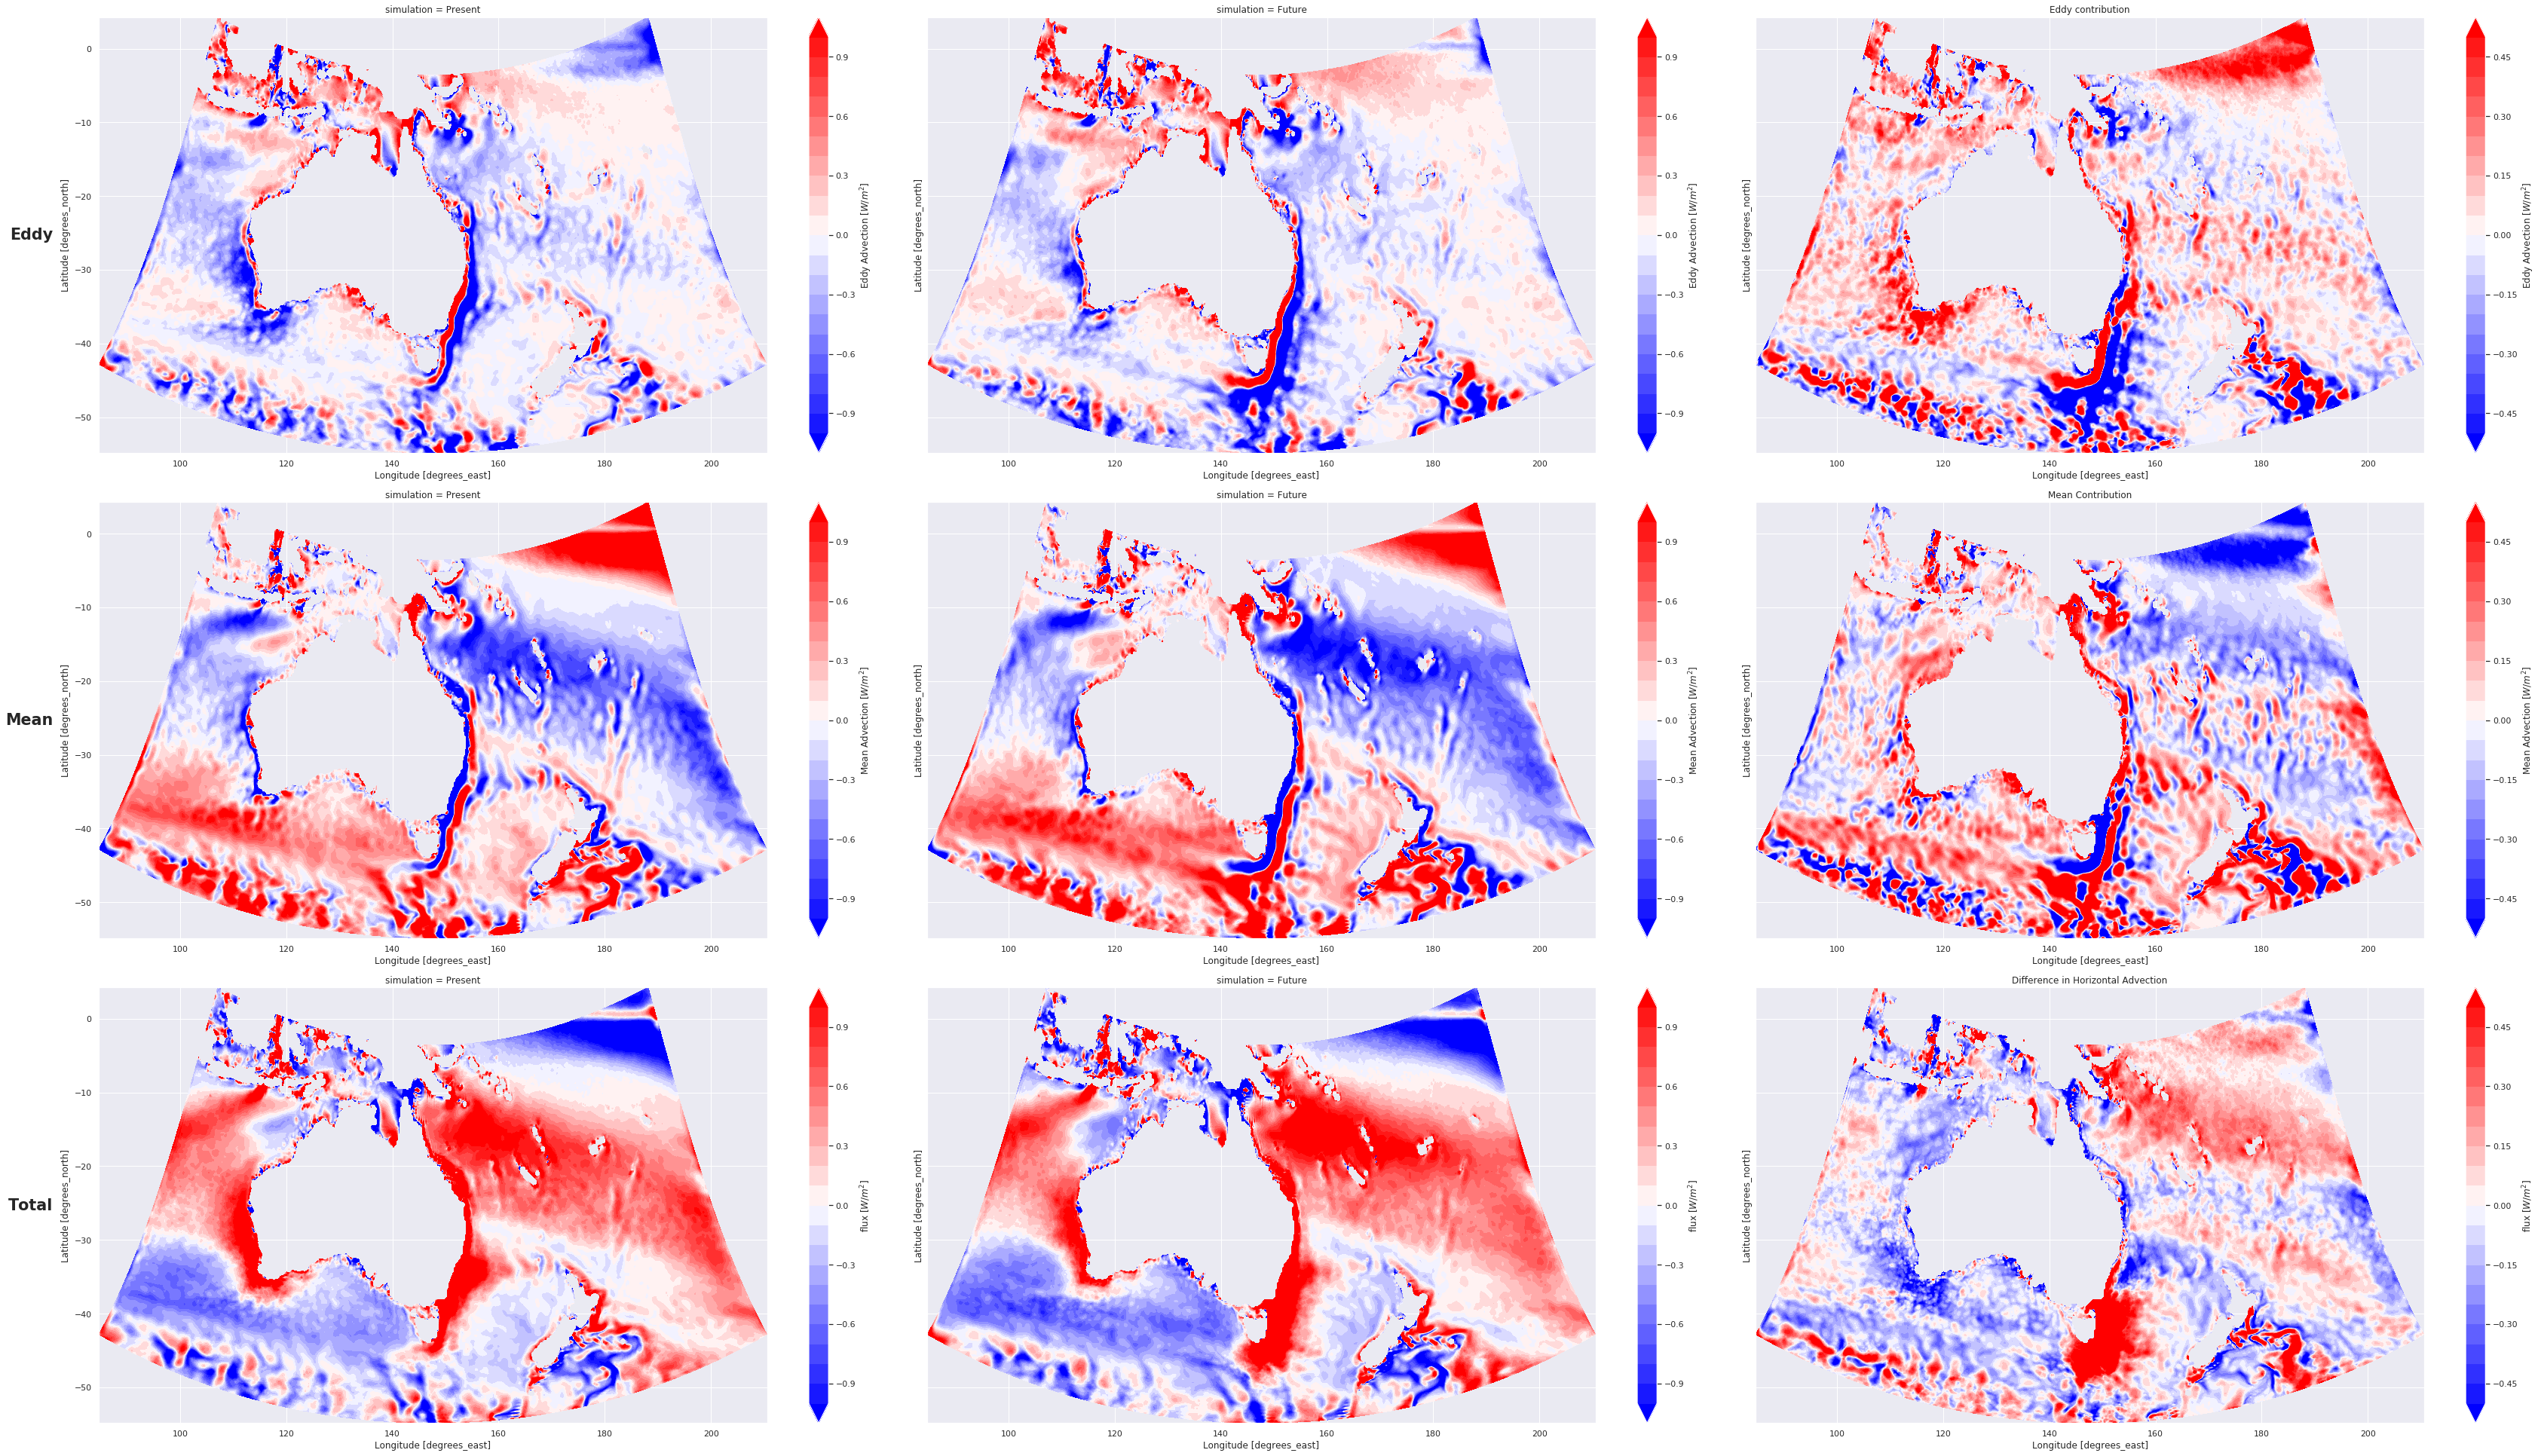

In [587]:
fig, ax = plt.subplots(3,3, sharey = True, figsize = [48, 27])
vmin, vmax = (-1,1)
vmin1, vmax1 = (-0.5, 0.5)
num_levels = 21
ehf.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0,0], 
                                     cbar_kwargs = {'label' : 'Eddy Advection [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
ehf.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0,1],
                                             cbar_kwargs = {'label' : 'Eddy Advection [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
ehf_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[0,2], 
                       cbar_kwargs = {'label' : 'Eddy Advection [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
ax[0,2].set_title('Eddy contribution');

mhf.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1,0], 
                                     cbar_kwargs = {'label' : 'Mean Advection [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
mhf.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1,1],
                                             cbar_kwargs = {'label' : 'Mean Advection [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
mhf_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[1,2], 
                       cbar_kwargs = {'label' : 'Mean Advection [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
ax[1,2].set_title('Mean Contribution')

adv.sel(simulation = 'Present').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2,0], cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin= vmin, vmax = vmax, cmap = cmap_dif)
adv.sel(simulation = 'Future').plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2,1],cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, vmin = vmin, vmax = vmax, cmap = cmap_dif)
adv_diff.plot.contourf(levels = num_levels, x='nav_lon', y ='nav_lat', ax = ax[2,2, cbar_kwargs = {'label' : 'flux [$W/m^2$]'}, cmap = cmap_dif, vmin = vmin1, vmax = vmax1);
ax[2,2].set_title('Difference in Horizontal Advection');

rows = ['Eddy', 'Mean', 'Total']
pad = 7

for axes, row in zip(ax[:,0], rows):
    axes.annotate(row, xy=(0, 0.5), xytext=(-axes.yaxis.labelpad - pad, 0),xycoords=axes.yaxis.label, textcoords='offset points',
                size='xx-large', ha='right', va='center', fontweight = 'bold')

fig.tight_layout()
# plt.savefig('/home/561/rm6294/Documents/Heat_Flux/advection_comparison.png')

# Random Stuff 

##### No idea what this shows, but it looks cool!
I think I plotted the difference in MLD for a single y coordinates. Trying to show seasonal variation at a single grid point?

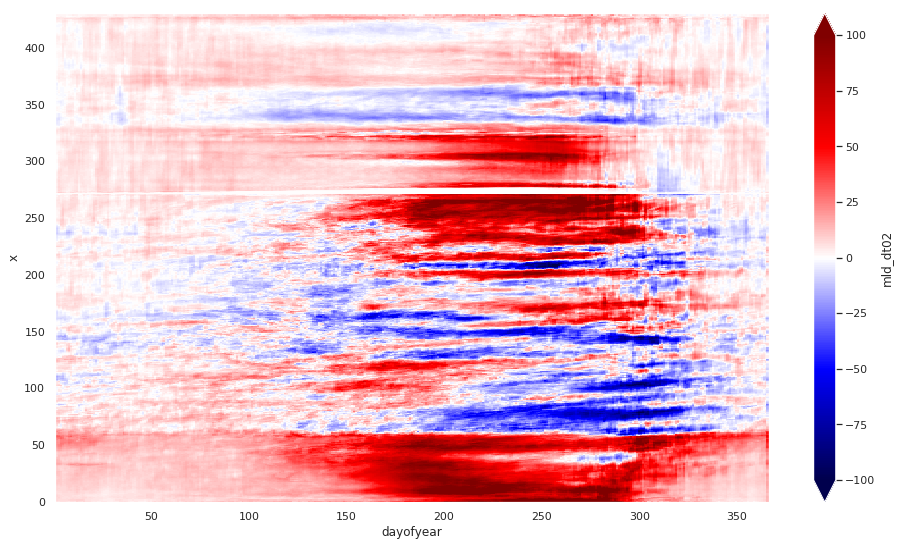

In [331]:
vmin, vmax = (-100, 100)
index = 20
(mld_seas.sel(simulation = 'Present') - mld_seas.sel(simulation = 'Future')).isel(y = index).transpose().plot(vmin = vmin, vmax = vmax, cmap = cmap_dif);